## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geoim' #dataset-compression
TRANSFORM = 'fft-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_fft_1e5geoim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geoim\\fft\\statement_2'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


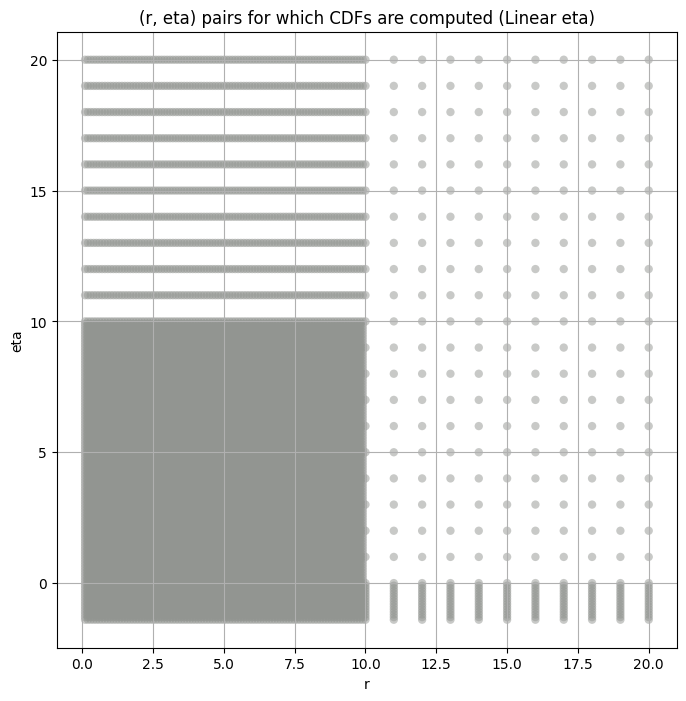

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,3.026685e+14,2.582338e+14,3.561559e+14,9.514625,3.957884,14.501236,1440.0
5,4.619870e+14,3.780415e+14,5.561503e+14,47.110716,38.247552,56.023000,4320.0
8,8.093079e+13,6.675209e+13,9.716262e+13,51.453747,35.541977,65.114411,12240.0
11,8.157558e+12,7.539994e+12,8.999805e+12,10.165148,2.219676,28.457157,33840.0
14,2.080089e+14,1.803587e+14,2.405816e+14,29.306278,17.520988,50.394668,93600.0
17,3.882312e+14,3.622117e+14,4.166798e+14,5.403622,3.651718,8.761791,100000.0
20,1.055298e+14,9.708171e+13,1.151467e+14,8.822809,5.236424,19.120294,100000.0
23,1.033205e+13,9.617393e+12,1.125343e+13,7.130255,2.946967,23.835721,100000.0
26,4.816557e+12,4.516951e+12,5.143129e+12,4.306077,2.829495,8.496249,100000.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,3.026685e+14,3.026685e+14,2.070723e+14,1.784807e+14,1.597261e+14,1.451466e+14,1.219981e+14,1.036122e+14,8.976535e+13,7.860606e+13,6.895072e+13,4.676781e+13
5,4.619870e+14,4.619870e+14,2.475832e+14,1.785933e+14,1.433303e+14,1.241354e+14,1.038355e+14,9.286857e+13,8.494503e+13,7.858054e+13,7.338216e+13,6.146725e+13
8,8.093079e+13,8.093079e+13,5.812857e+13,4.893168e+13,4.390992e+13,4.066420e+13,3.691714e+13,3.469491e+13,3.315474e+13,3.193129e+13,3.085747e+13,2.825313e+13
11,8.157558e+12,8.157558e+12,7.664053e+12,7.480574e+12,7.348870e+12,7.246948e+12,7.076576e+12,6.935620e+12,6.816113e+12,6.710897e+12,6.615531e+12,6.370094e+12
14,2.080089e+14,2.080089e+14,1.917548e+14,1.837323e+14,1.775451e+14,1.721704e+14,1.630257e+14,1.552991e+14,1.486855e+14,1.429066e+14,1.376624e+14,1.243741e+14
17,3.882312e+14,3.882312e+14,3.771246e+14,3.703794e+14,3.647872e+14,3.599041e+14,3.515565e+14,3.443915e+14,3.380577e+14,3.322788e+14,3.269715e+14,3.130627e+14
20,1.055298e+14,1.055298e+14,1.014108e+14,9.911460e+13,9.728675e+13,9.572961e+13,9.308431e+13,9.083573e+13,8.885371e+13,8.706109e+13,8.541581e+13,8.112443e+13
23,1.033205e+13,1.033205e+13,9.945874e+12,9.762856e+12,9.619885e+12,9.498284e+12,9.293530e+12,9.120038e+12,8.967275e+12,8.829416e+12,8.702725e+12,8.372062e+12
26,4.816557e+12,4.816557e+12,4.695999e+12,4.622837e+12,4.562098e+12,4.508540e+12,4.415141e+12,4.334093e+12,4.261387e+12,4.194947e+12,4.133500e+12,3.971363e+12


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.010433271839781932 302668547674595.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.015193520999118908 207072344452879.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.024796970837249854 178480668686090.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.034857800654021 159726067368261.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.045785591886602584 145146632913228.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.06540525816947199 121998140508514.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.08336614484810057 103612155314135.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.09853775565250084 89765352541189.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1120066076651961 78606063988205.92


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.12601714204644499 68950724160171.69


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.1636089823466287 46767807276308.64
Number of samples: 2880, Without approximation : 1440.0


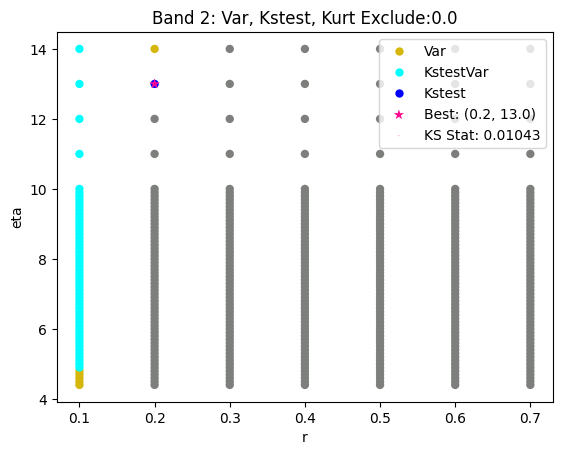

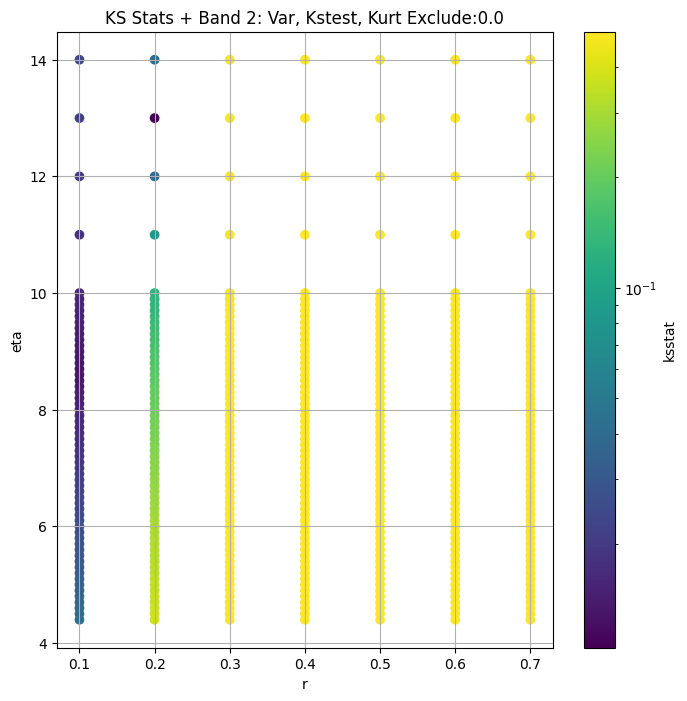

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.017250487398262786 461986969653092.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.017250487398262786 247583163090681.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.01232844825774937 178593348671266.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.011082097147787743 143330286618036.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.013107404281264882 124135422427497.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.019243231482179775 103835462246054.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.025215125820063133 92868573169176.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03381875454868055 84945026512368.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.04199000614834747 78580537627364.83


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.04899147003919946 73382160360574.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.06636682354325096 61467253939311.164
Number of samples: 8640, Without approximation : 4320.0


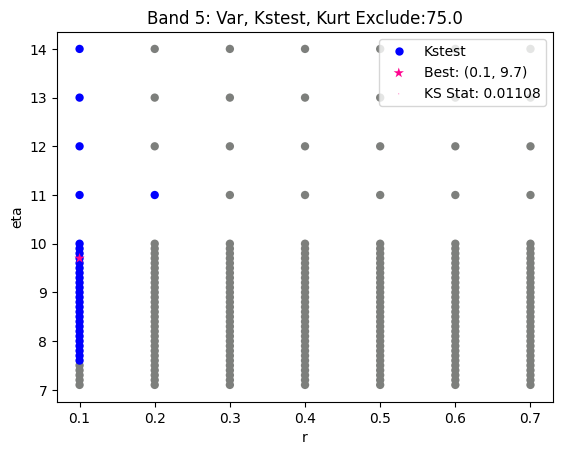

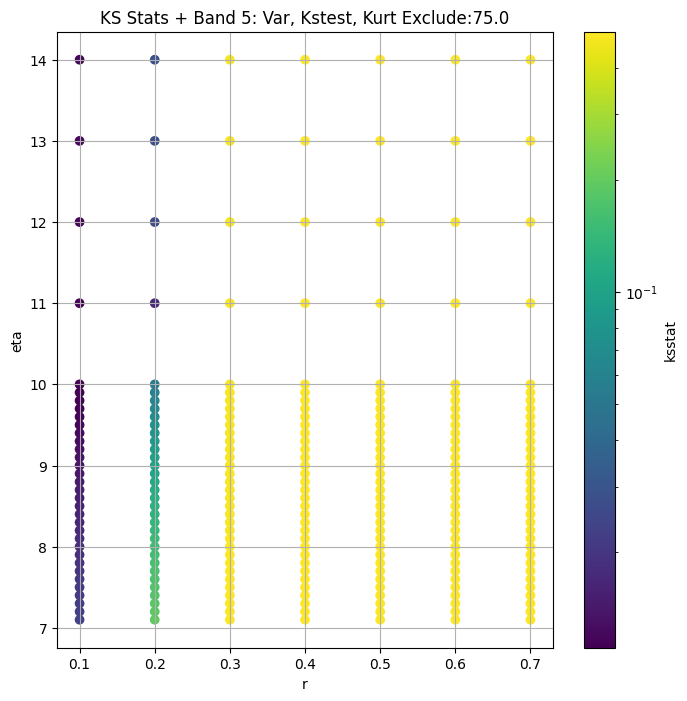

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.006752468241253015 80930789219971.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006752468241253015 58128566262162.54


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006752468241253015 48931678085361.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006752468241253015 43909922945410.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005788030084874274 40664198168142.57


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.007418298282235725 36917142274113.85


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.009408204842873238 34694907916067.797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.011364689436227579 33154740165951.99


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.014945091278028927 31931290098107.145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.01884610661425981 30857468792273.15


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.0289255264426313 28253129389576.105
Number of samples: 24480, Without approximation : 12240.0


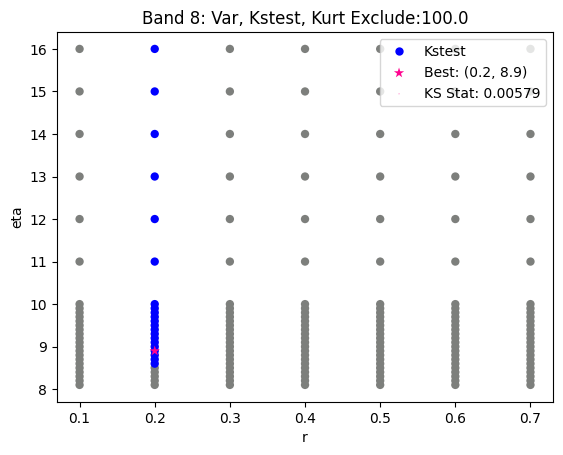

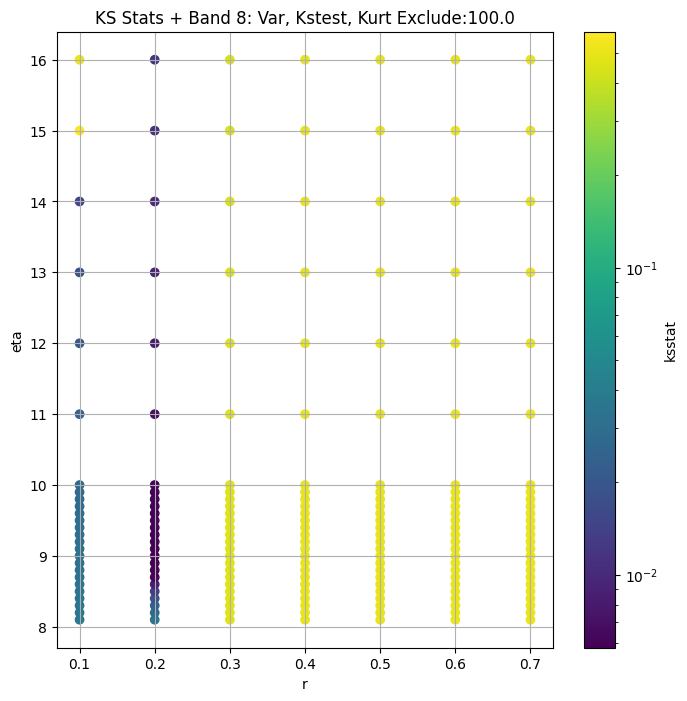

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.006945135502741562 8157558089721.551


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.004076042273798153 7664053269881.282


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0030259730789720107 7480574342720.701


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.002039316150263981 7348869960420.213


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.00216800751473889 7246948103186.847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.004012043983087632 7076575775934.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.006314071931042942 6935620052270.895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.0083021767038165 6816112517760.51


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.010080886511284581 6710896981044.633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.01171657387665448 6615531142886.189


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.01603244131477566 6370094086231.863
Number of samples: 67680, Without approximation : 33840.0


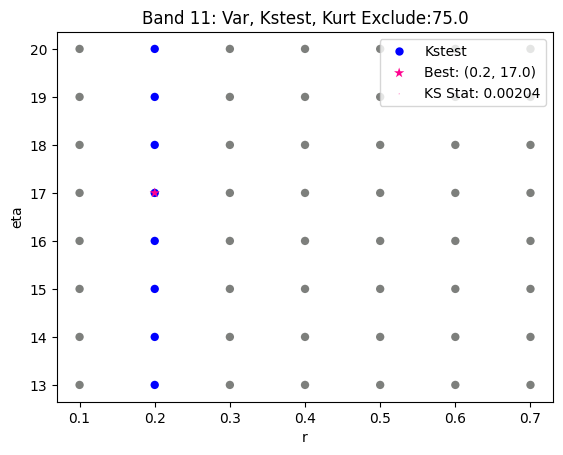

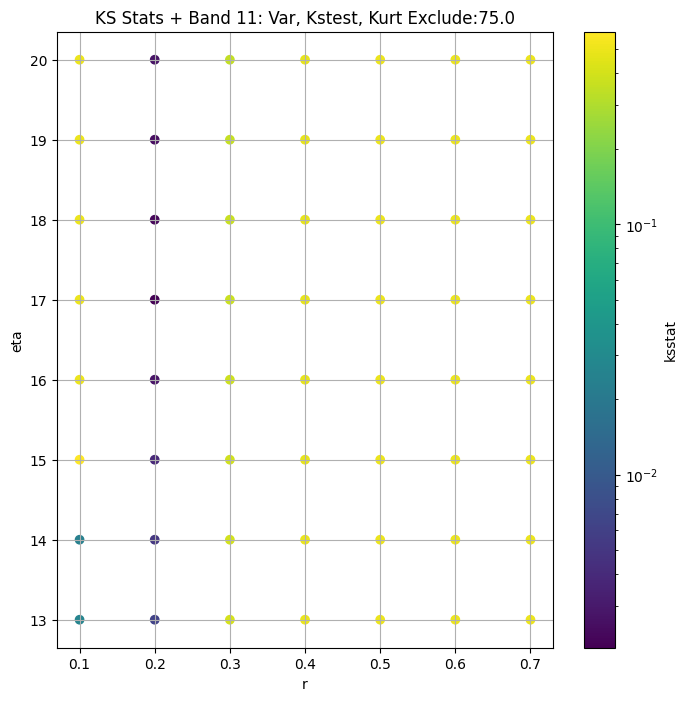

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.024161635838307827 208008922645440.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.02626729431680641 191754814241598.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.02371859091000006 183732299398961.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.021675661410269442 177545051698350.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02113866884903587 172170417847156.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.023059728408102997 163025670012189.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.023496659067128167 155299140170024.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.023241469976149585 148685476595730.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.024435214259939636 142906633657106.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.02528680453721943 137662377223157.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.026637800275562742 124374089455462.67
Number of samples: 100000, Without approximation : 93600.0


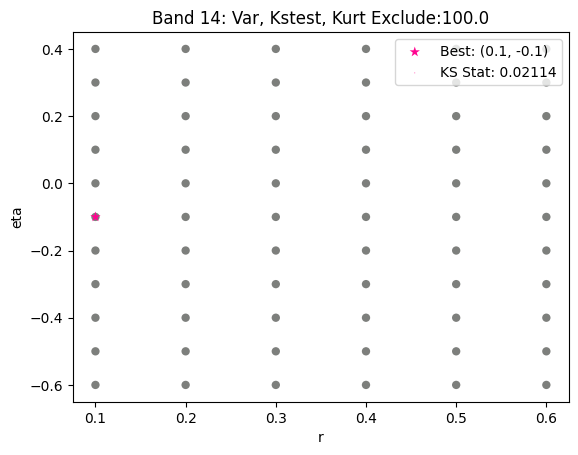

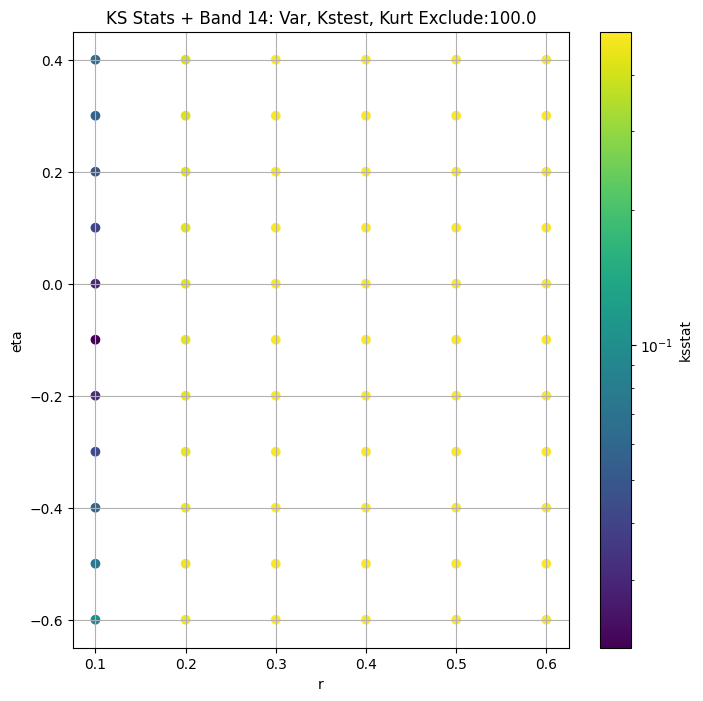

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.00824140279267005 388231177504978.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.008868909696965743 377124564161348.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.009261412117523071 370379369097566.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.009608550236439972 364787228272643.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.009796212606125329 359904103869563.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.010528236801998173 351556513361267.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.01115252318313556 344391451053081.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.011682903510219167 338057748074793.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.012151566417865856 332278824821795.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.012592529949274067 326971508511942.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.014025230092338081 313062726459432.25
Number of samples: 100000, Without approximation : 100000.0


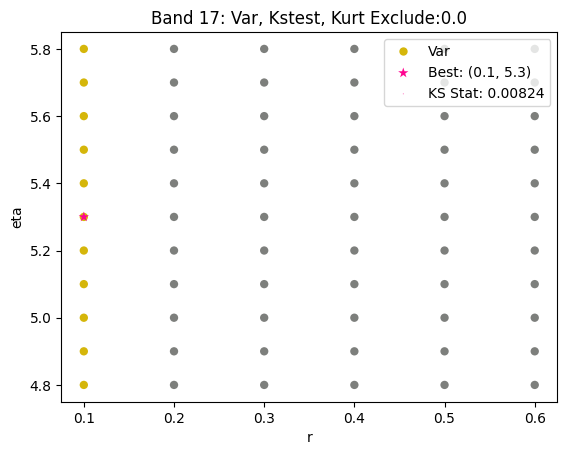

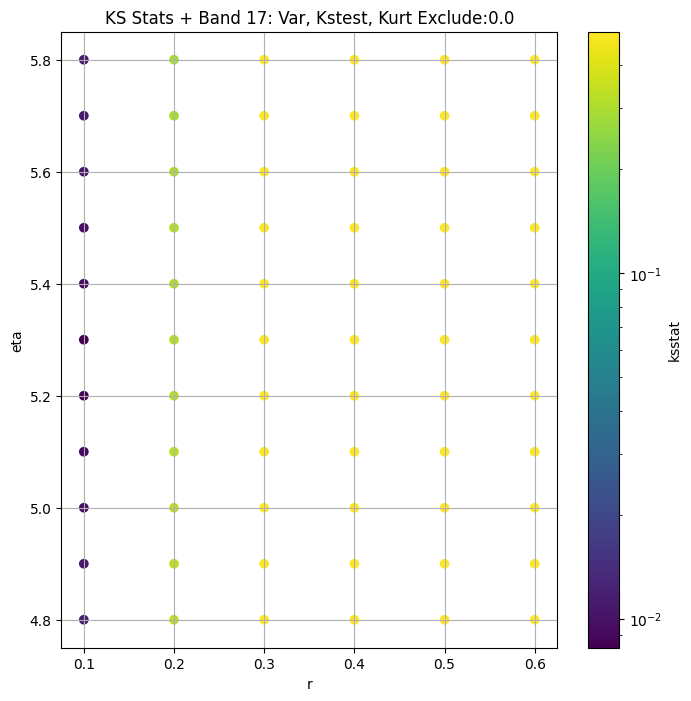

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.003494048644809289 105529795134163.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.00280127021023846 101410768375533.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.002291943710653676 99114597479027.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.0028605902281108563 97286754216886.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.003358933431072273 95729609362192.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.004282803527332693 93084310261645.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.00514440813697014 90835733404153.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.005970853331333487 88853710570764.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.006760922945745634 87061086431326.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.007511282086865651 85415809808616.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.009619799186524766 81124426390298.33
Number of samples: 100000, Without approximation : 100000.0


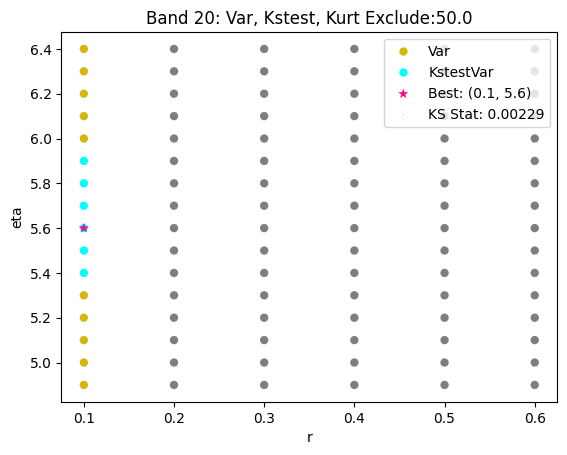

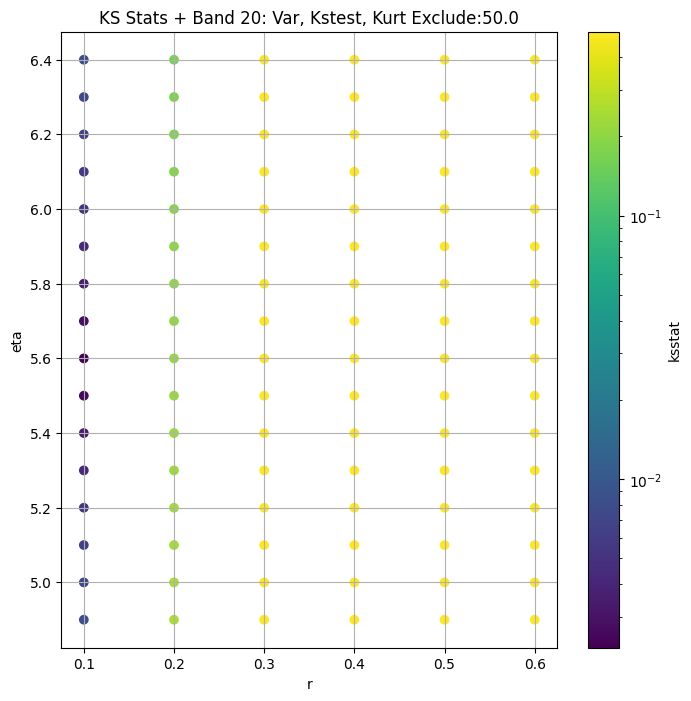

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0026941500672913454 10332048042010.348


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0022739613403097714 9945873694568.676


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0010655492008825873 9762855611958.594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0014855054316471484 9619885499513.266


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0018016425502345827 9498284043568.367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0026013334191624937 9293530402753.729


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0034684712451355376 9120038478384.947


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004344593151871287 8967275012744.629


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005161752707471011 8829415526396.758


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.005934915784607503 8702724877526.404


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.00809641844870019 8372061564773.764
Number of samples: 100000, Without approximation : 100000.0


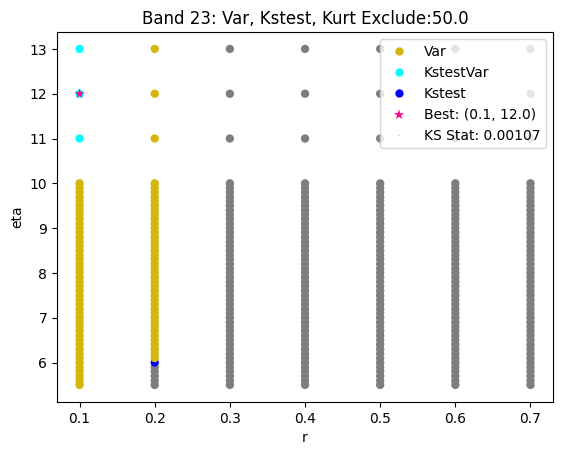

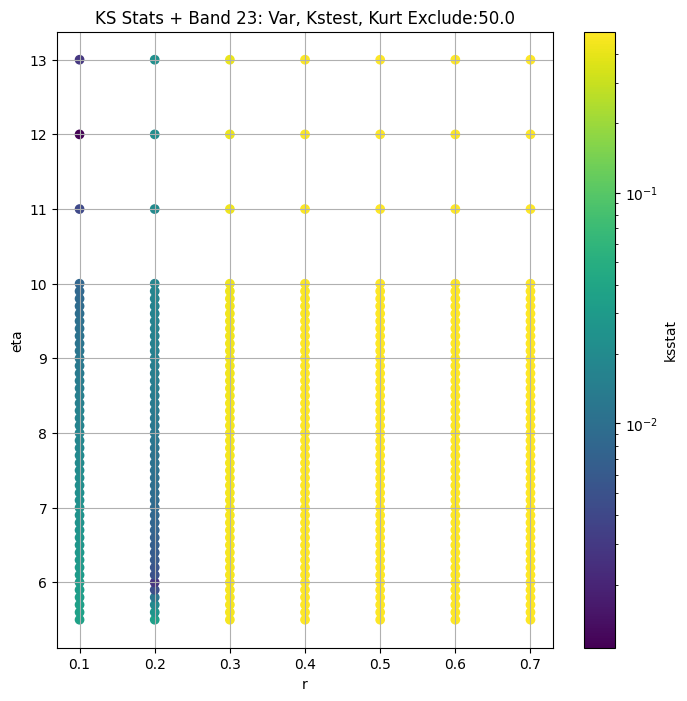

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.00042295998585634154 4816557122466.155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0012325762983983052 4695999061563.261


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0019007537860549623 4622836681581.665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0025451103389999494 4562097625993.073


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.003234451424540666 4508539837989.807


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.0036771118489733814 4415141347885.633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.004538650257103594 4334092718600.5576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005366645324087468 4261386955471.159


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006159990865059875 4194946852204.3467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.0069226144082485674 4133499953724.0464


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.0090432276618009 3971363218169.962
Number of samples: 100000, Without approximation : 100000.0


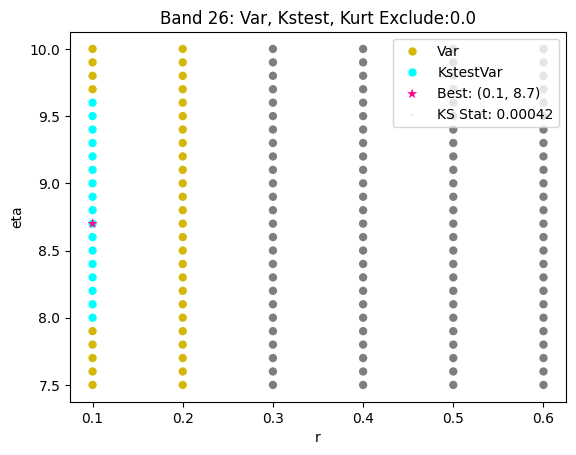

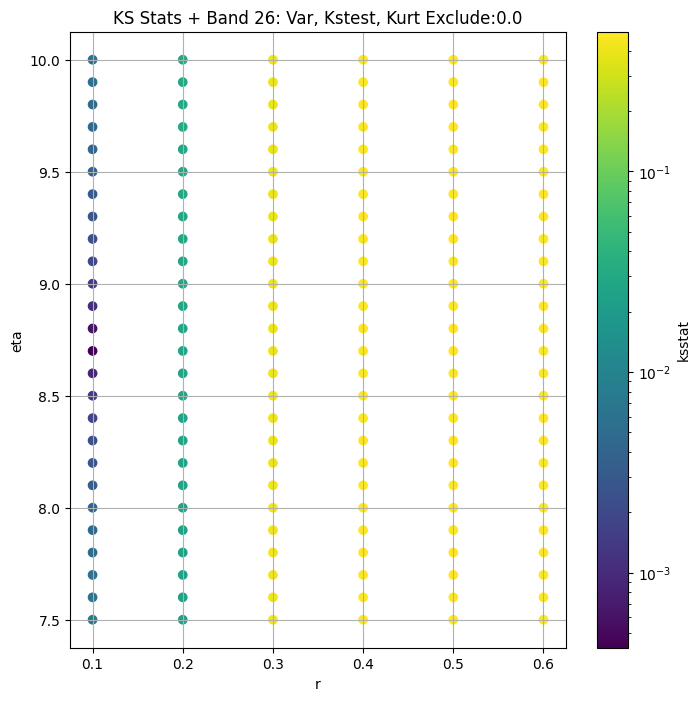

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.0030216023627224337 63970592978.84248


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.0031892737269080262 61724870235.59367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.0038956413338811224 60423790510.08322


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.004421171108527688 59355110880.336876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.004900736797670988 58423559252.17106


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.005941749094658971 56817457238.937035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.006687521182039406 55435061731.088394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.007531696403991532 54206232921.569626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.008352379846180868 53091036348.87613


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.009112069393450772 52065353075.63156


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.011153281221024006 49388316213.23899
Number of samples: 100000, Without approximation : 100000.0


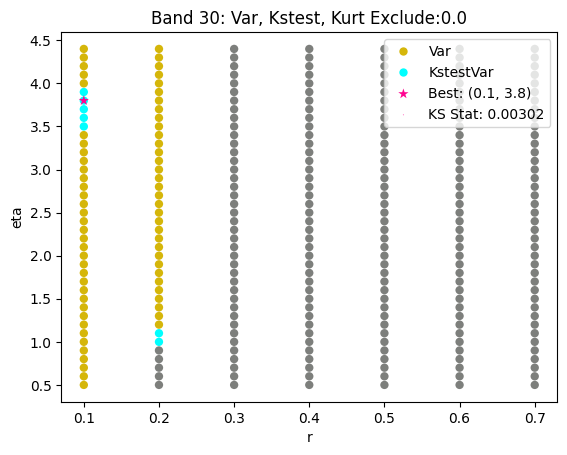

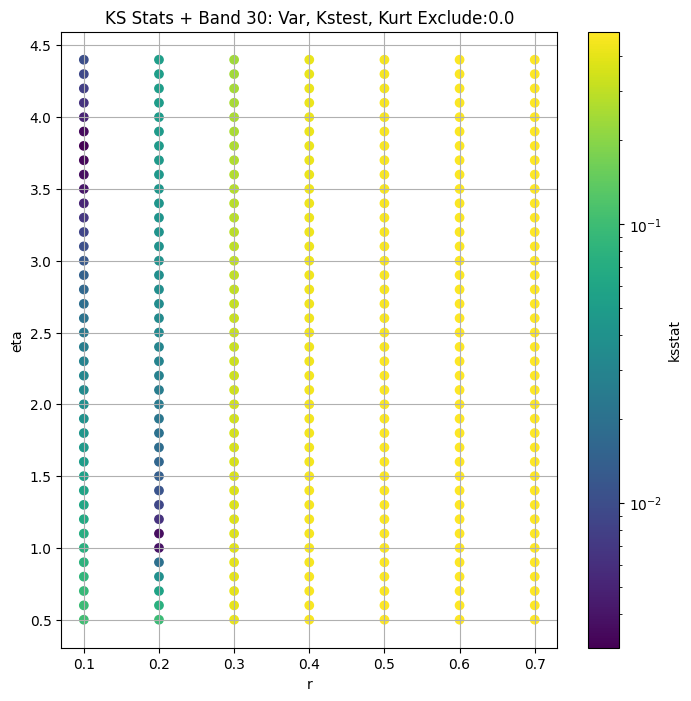

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,3.026685e+14,2.582338e+14,3.561559e+14,9.514625,3.957884,14.501236,1440.0,0.010433,0.2,13.0,1.000000e+05,0.0,3.026685e+14,0.035671
5,4.619870e+14,3.780415e+14,5.561503e+14,47.110716,38.247552,56.023000,4320.0,0.011082,0.1,9.7,3.121759e-07,75.0,1.433303e+14,0.020624
8,8.093079e+13,6.675209e+13,9.716262e+13,51.453747,35.541977,65.114411,12240.0,0.005788,0.2,8.9,8.871326e+04,100.0,4.066420e+13,0.012262
11,8.157558e+12,7.539994e+12,8.999805e+12,10.165148,2.219676,28.457157,33840.0,0.002039,0.2,17.0,9.756740e+02,75.0,7.348870e+12,0.007378
14,2.080089e+14,1.803587e+14,2.405816e+14,29.306278,17.520988,50.394668,93600.0,0.021139,0.1,-0.1,4.147099e+01,100.0,1.721704e+14,0.004437
17,3.882312e+14,3.622117e+14,4.166798e+14,5.403622,3.651718,8.761791,100000.0,0.008241,0.1,5.3,9.752666e-05,0.0,3.882312e+14,0.004293
20,1.055298e+14,9.708171e+13,1.151467e+14,8.822809,5.236424,19.120294,100000.0,0.002292,0.1,5.6,1.658880e-05,50.0,9.911460e+13,0.004293
23,1.033205e+13,9.617393e+12,1.125343e+13,7.130255,2.946967,23.835721,100000.0,0.001066,0.1,12.0,3.505546e-09,50.0,9.762856e+12,0.004293
26,4.816557e+12,4.516951e+12,5.143129e+12,4.306077,2.829495,8.496249,100000.0,0.000423,0.1,8.7,2.575260e-08,0.0,4.816557e+12,0.004293


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.05122951238519835, var: 145146632913228.38


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.04063297717337877, var: 159726067368261.4


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.028264745458245644, var: 178480668686090.3


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.015249162327193977, var: 207072344452879.2


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.010433271839781932, var: 302668547674595.94
Number of samples: 2880, Without approximation : 1440.0


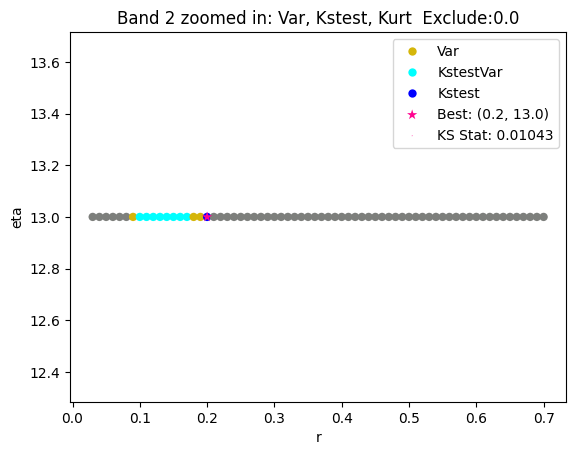

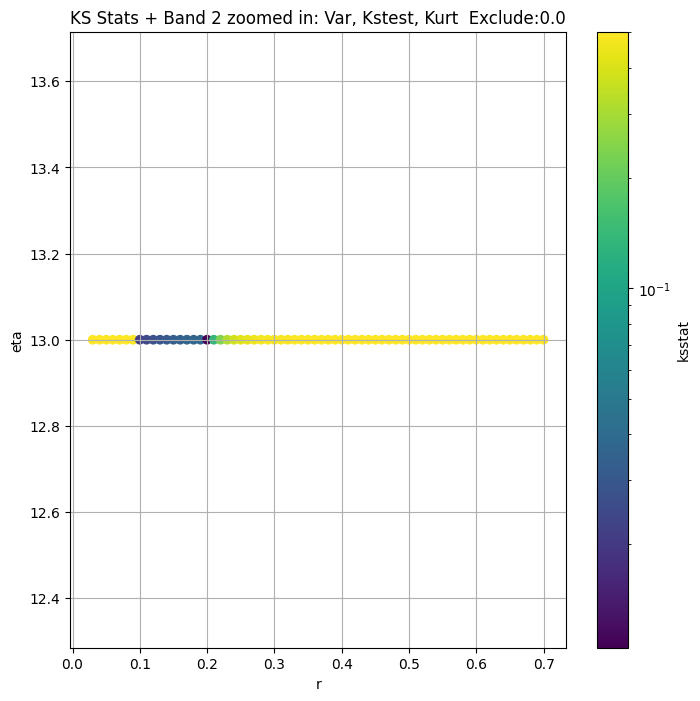

Band 5


  0%|          | 0/463 [00:00<?, ?it/s]

Finding Minimum after computing 463 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.02708077649842186, var: 97642136510002.44


  0%|          | 0/463 [00:00<?, ?it/s]

Finding Minimum after computing 463 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.020816437552660716, var: 103835462246054.61


  0%|          | 0/463 [00:00<?, ?it/s]

Finding Minimum after computing 463 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.016245241689521475, var: 111704593092763.34


  0%|          | 0/463 [00:00<?, ?it/s]

Finding Minimum after computing 463 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.013033364399716717, var: 124135422427497.22


  0%|          | 0/463 [00:00<?, ?it/s]

Finding Minimum after computing 463 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.011082097147787743, var: 143330286618036.94


  0%|          | 0/463 [00:00<?, ?it/s]

Finding Minimum after computing 463 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.013750747325500301, var: 178593348671266.97


  0%|          | 0/463 [00:00<?, ?it/s]

Finding Minimum after computing 463 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.03643477717370548, var: 247583163090681.16


  0%|          | 0/463 [00:00<?, ?it/s]

Finding Minimum after computing 463 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.053190553276624086, var: 461986969653092.0
Number of samples: 8640, Without approximation : 4320.0


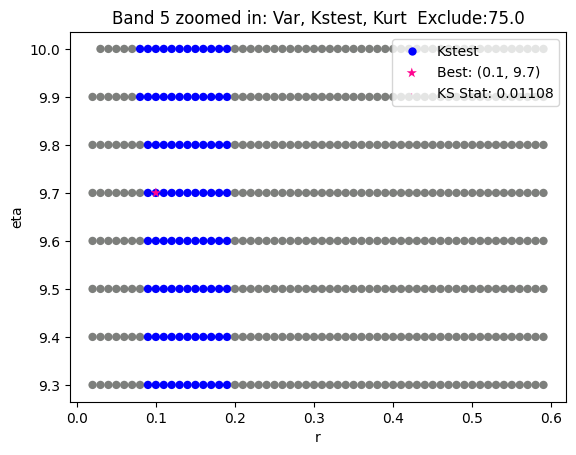

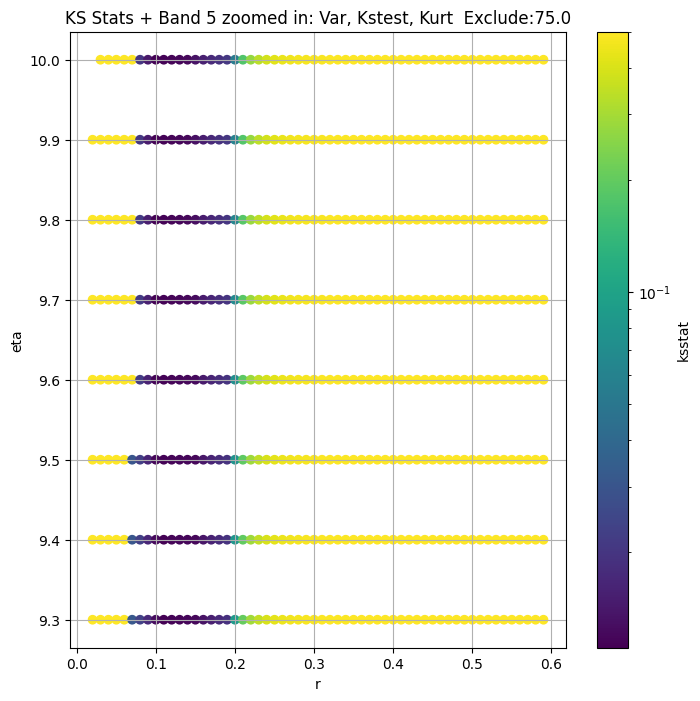

Band 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 100.0 + 100 = 200, ksstat: 0.019699004031046907, var: 34694907916067.797


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 100.0 + 75 = 175, ksstat: 0.01688491026496286, var: 35700028546673.27


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 100.0 + 50 = 150, ksstat: 0.013605925764311577, var: 36917142274113.85


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 100.0 + 25 = 125, ksstat: 0.009473974826436748, var: 38525503383712.33


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 100.0 + 0 = 100, ksstat: 0.005788030084874274, var: 40664198168142.57


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 100.0 + -25 = 75, ksstat: 0.006752468241253015, var: 43909922945410.55


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 100.0 + -50 = 50, ksstat: 0.006752468241253015, var: 48931678085361.74


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 100.0 + -75 = 25, ksstat: 0.006752468241253015, var: 58128566262162.54


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 100.0 + -100 = 0, ksstat: 0.006752468241253015, var: 80930789219971.47
Number of samples: 24480, Without approximation : 12240.0


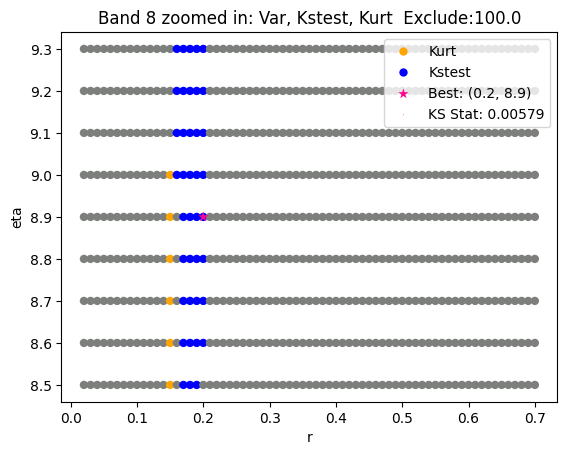

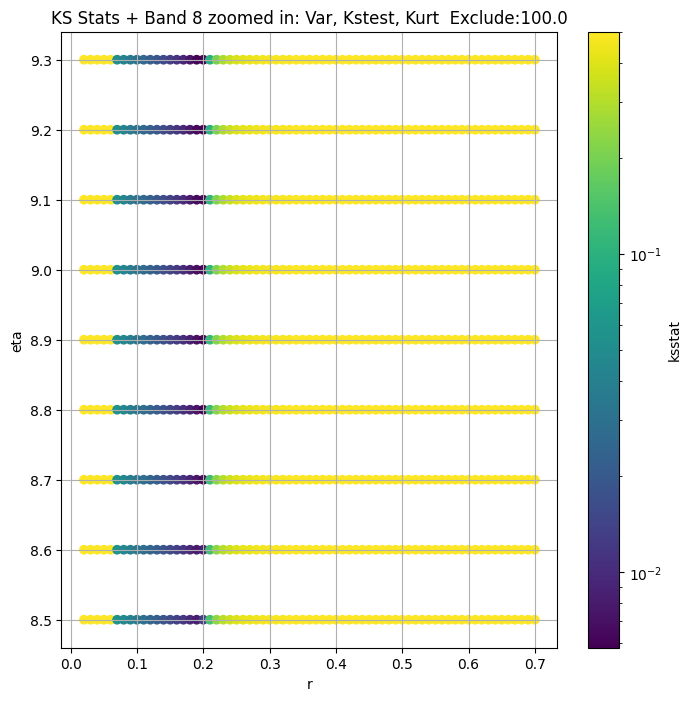

Band 11


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 100 = 175, ksstat: 0.004777681498324804, var: 7002895162917.525


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 75 = 150, ksstat: 0.0035782640087230755, var: 7076575775934.42


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 50 = 125, ksstat: 0.0025734247748312507, var: 7157188639817.243


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 25 = 100, ksstat: 0.0021553467485274647, var: 7246948103186.847


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 0 = 75, ksstat: 0.002039316150263981, var: 7348869960420.213


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + -25 = 50, ksstat: 0.0027863171174596912, var: 7480574342720.701


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + -50 = 25, ksstat: 0.004133312611375839, var: 7664053269881.282


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + -75 = 0, ksstat: 0.007851739552485304, var: 8157558089721.551
Number of samples: 67680, Without approximation : 33840.0


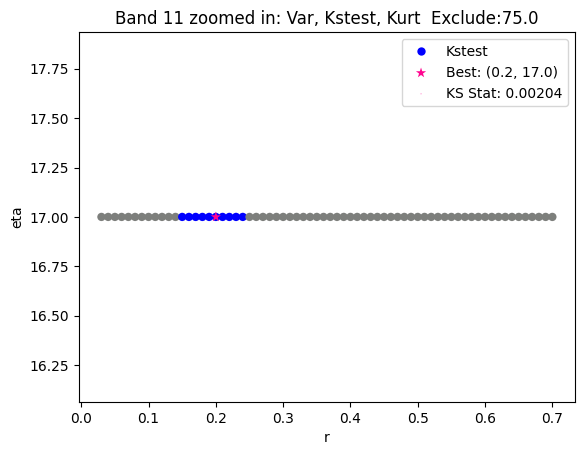

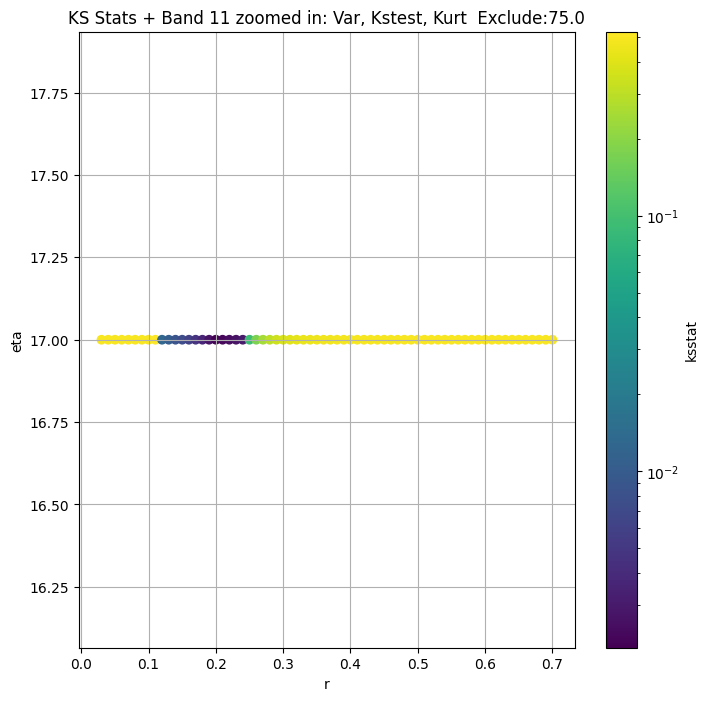

Band 14


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 100 = 200, ksstat: 0.0222132147408306, var: 155299140170024.25


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 75 = 175, ksstat: 0.02176697839555853, var: 159018689817064.6


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 50 = 150, ksstat: 0.021599072802876873, var: 163025670012189.1


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 25 = 125, ksstat: 0.021233255496109445, var: 167396647997375.88


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 0 = 100, ksstat: 0.020866757878610594, var: 172170417847156.9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + -25 = 75, ksstat: 0.020977807653357716, var: 177545051698350.25


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + -50 = 50, ksstat: 0.021627181000477336, var: 183732299398961.84


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + -75 = 25, ksstat: 0.02203500652341428, var: 191754814241598.8


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + -100 = 0, ksstat: 0.021244921658621574, var: 208008922645440.62
Number of samples: 100000, Without approximation : 93600.0


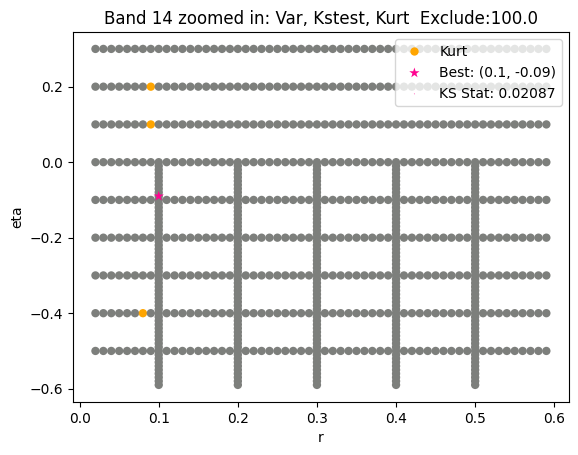

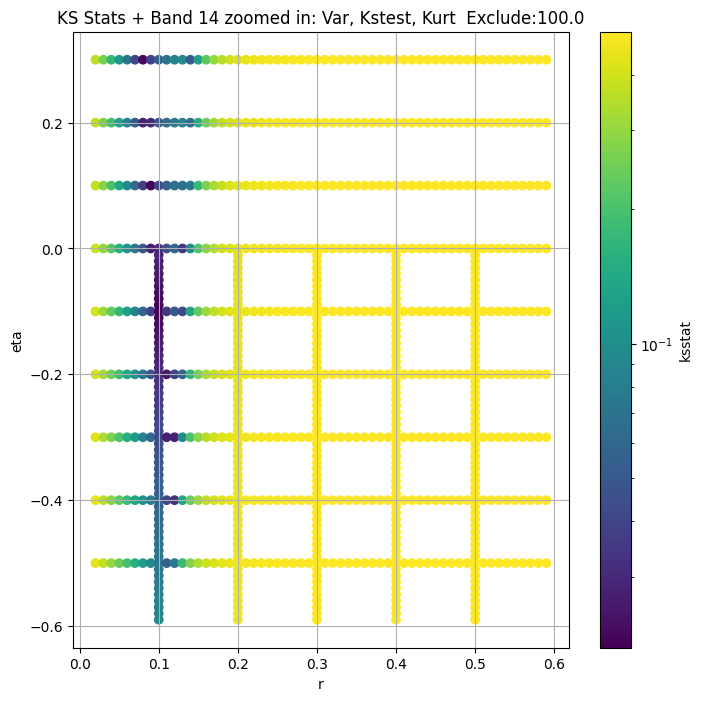

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.009646863621376456, var: 359904103869563.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.009515829560327232, var: 364787228272643.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.009070188062834439, var: 370379369097566.5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.008536451262113665, var: 377124564161348.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.00824140279267005, var: 388231177504978.1
Number of samples: 100000, Without approximation : 100000.0


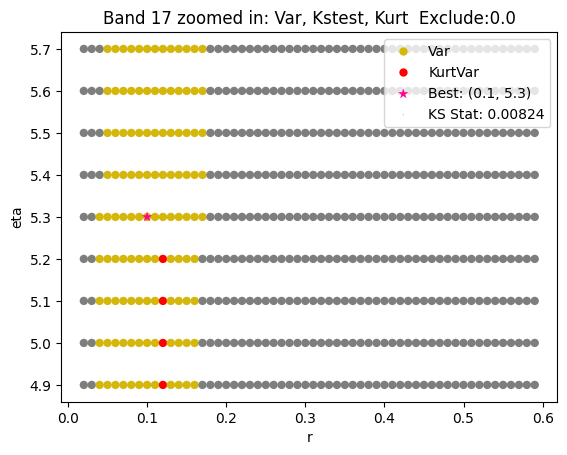

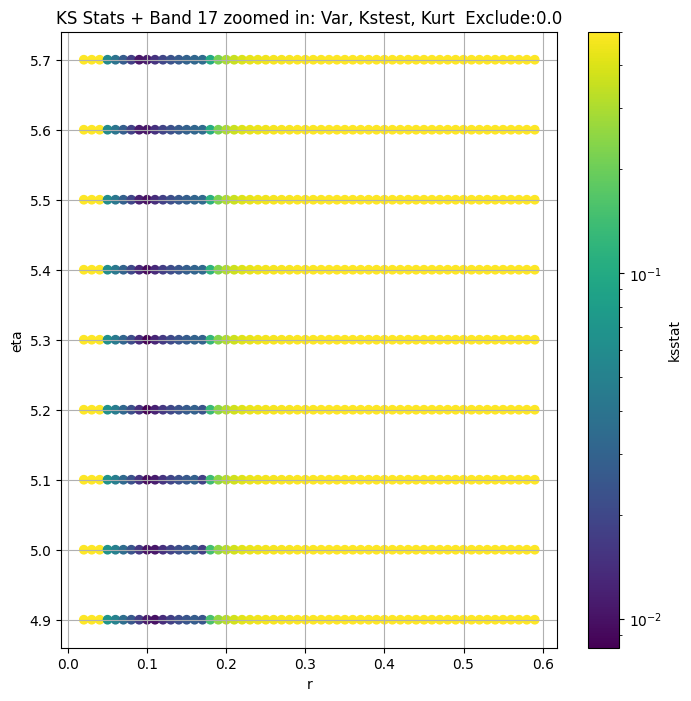

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 100 = 150, ksstat: 0.0042235924856492794, var: 93084310261645.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 75 = 125, ksstat: 0.0037983889032350907, var: 94341803613709.19


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 50 = 100, ksstat: 0.0033236484323591713, var: 95729609362192.7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 25 = 75, ksstat: 0.0028379387476279196, var: 97286754216886.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 0 = 50, ksstat: 0.002291943710653676, var: 99114597479027.19


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + -25 = 25, ksstat: 0.00280127021023846, var: 101410768375533.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + -50 = 0, ksstat: 0.003356415207075858, var: 105529795134163.84
Number of samples: 100000, Without approximation : 100000.0


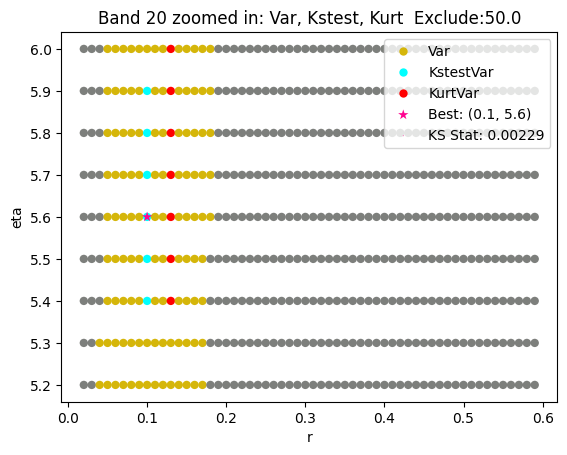

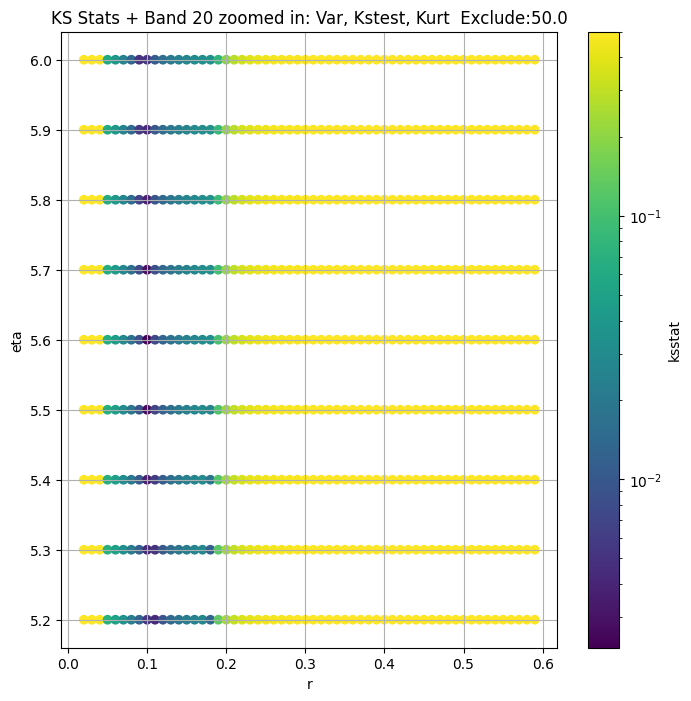

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 100 = 150, ksstat: 0.0027427952396951727, var: 9293530402753.729


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 75 = 125, ksstat: 0.002285785486779275, var: 9390974234614.424


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 50 = 100, ksstat: 0.0018549814062755882, var: 9498284043568.367


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 25 = 75, ksstat: 0.0021343988852349227, var: 9619885499513.266


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 0 = 50, ksstat: 0.0010655492008825873, var: 9762855611958.594


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -25 = 25, ksstat: 0.0022739613403097714, var: 9945873694568.676


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -50 = 0, ksstat: 0.0033614814159580453, var: 10332048042010.348
Number of samples: 100000, Without approximation : 100000.0


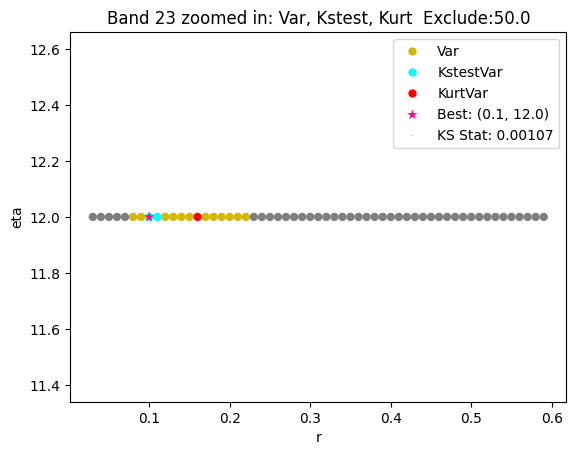

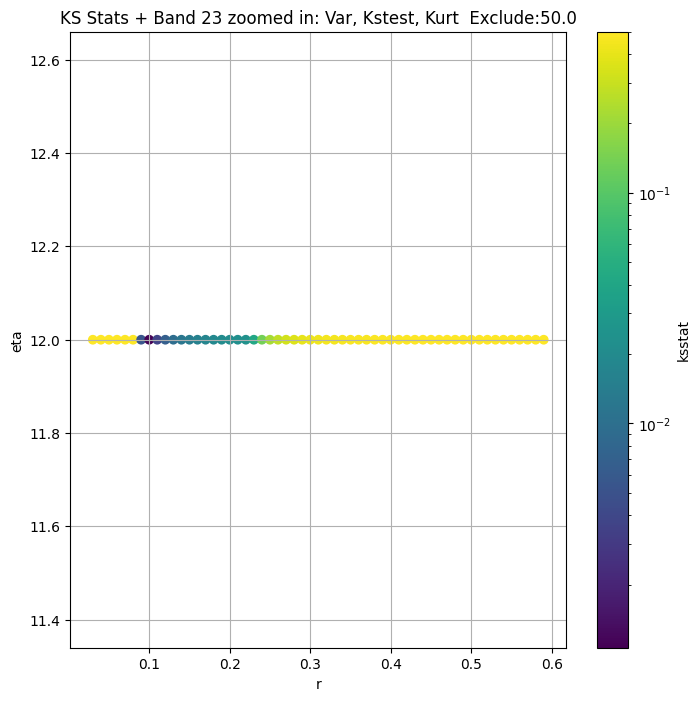

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.0029357990131101547, var: 4508539837989.807


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.002412431615406614, var: 4562097625993.073


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.0018648425958296445, var: 4622836681581.665


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.001199052001900694, var: 4695999061563.261


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.00042295998585634154, var: 4816557122466.155
Number of samples: 100000, Without approximation : 100000.0


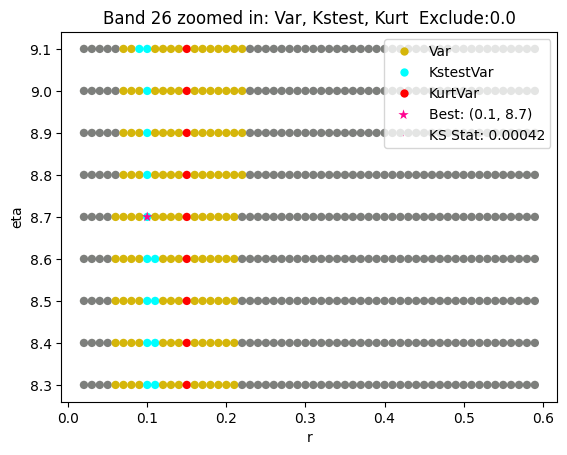

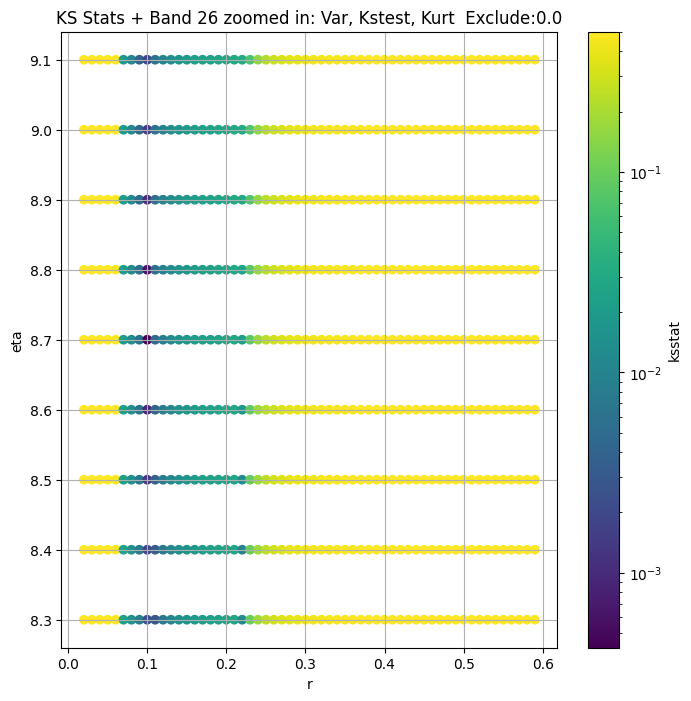

Band 30


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 100 = 100, ksstat: 0.005645744400221579, var: 58423559252.17106


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 75 = 75, ksstat: 0.0050795682543297235, var: 59355110880.336876


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 50 = 50, ksstat: 0.004674895261915106, var: 60423790510.08322


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 25 = 25, ksstat: 0.0038546380959297993, var: 61724870235.59367


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 0 = 0, ksstat: 0.0030216023627224337, var: 63970592978.84248
Number of samples: 100000, Without approximation : 100000.0


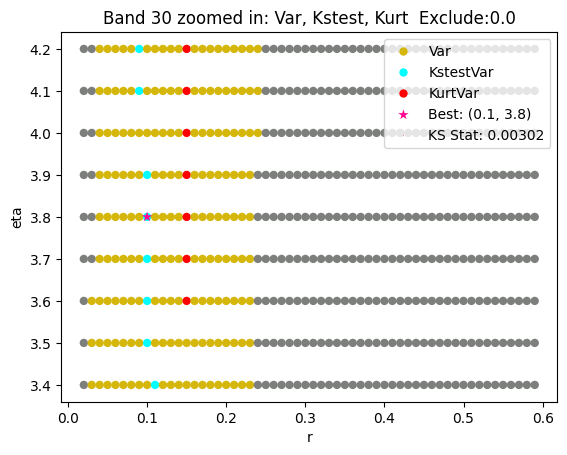

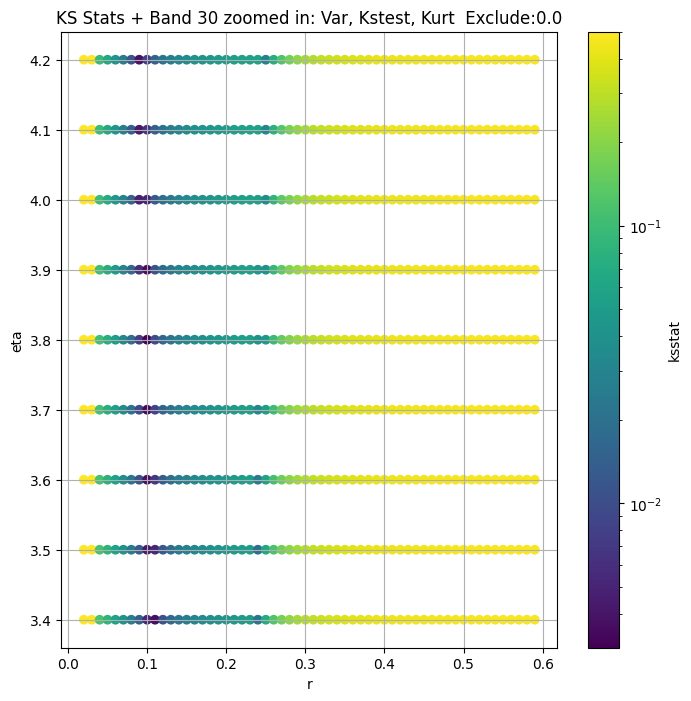

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,3.026685e+14,2.582338e+14,3.561559e+14,9.514625,3.957884,14.501236,1440.0,0.010433,0.2,13.0,1.000000e+05,0.0,3.026685e+14,0.035671,0.010433,0.2,13.00,1.000000e+05,0.0,16402
5,4.619870e+14,3.780415e+14,5.561503e+14,47.110716,38.247552,56.023000,4320.0,0.011082,0.1,9.7,3.121759e-07,75.0,1.433303e+14,0.020624,0.011082,0.1,9.70,3.121759e-07,75.0,14580
8,8.093079e+13,6.675209e+13,9.716262e+13,51.453747,35.541977,65.114411,12240.0,0.005788,0.2,8.9,8.871326e+04,100.0,4.066420e+13,0.012262,0.005788,0.2,8.90,8.871326e+04,100.0,52281
11,8.157558e+12,7.539994e+12,8.999805e+12,10.165148,2.219676,28.457157,33840.0,0.002039,0.2,17.0,9.756740e+02,75.0,7.348870e+12,0.007378,0.002039,0.2,17.00,9.756740e+02,75.0,433639
14,2.080089e+14,1.803587e+14,2.405816e+14,29.306278,17.520988,50.394668,93600.0,0.021139,0.1,-0.1,4.147099e+01,100.0,1.721704e+14,0.004437,0.020867,0.1,-0.09,3.924152e+01,100.0,4387
17,3.882312e+14,3.622117e+14,4.166798e+14,5.403622,3.651718,8.761791,100000.0,0.008241,0.1,5.3,9.752666e-05,0.0,3.882312e+14,0.004293,0.008241,0.1,5.30,9.752666e-05,0.0,28125
20,1.055298e+14,9.708171e+13,1.151467e+14,8.822809,5.236424,19.120294,100000.0,0.002292,0.1,5.6,1.658880e-05,50.0,9.911460e+13,0.004293,0.002292,0.1,5.60,1.658880e-05,50.0,337500
23,1.033205e+13,9.617393e+12,1.125343e+13,7.130255,2.946967,23.835721,100000.0,0.001066,0.1,12.0,3.505546e-09,50.0,9.762856e+12,0.004293,0.001066,0.1,12.00,3.505546e-09,50.0,1708593
26,4.816557e+12,4.516951e+12,5.143129e+12,4.306077,2.829495,8.496249,100000.0,0.000423,0.1,8.7,2.575260e-08,0.0,4.816557e+12,0.004293,0.000423,0.1,8.70,2.575260e-08,0.0,10391415


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

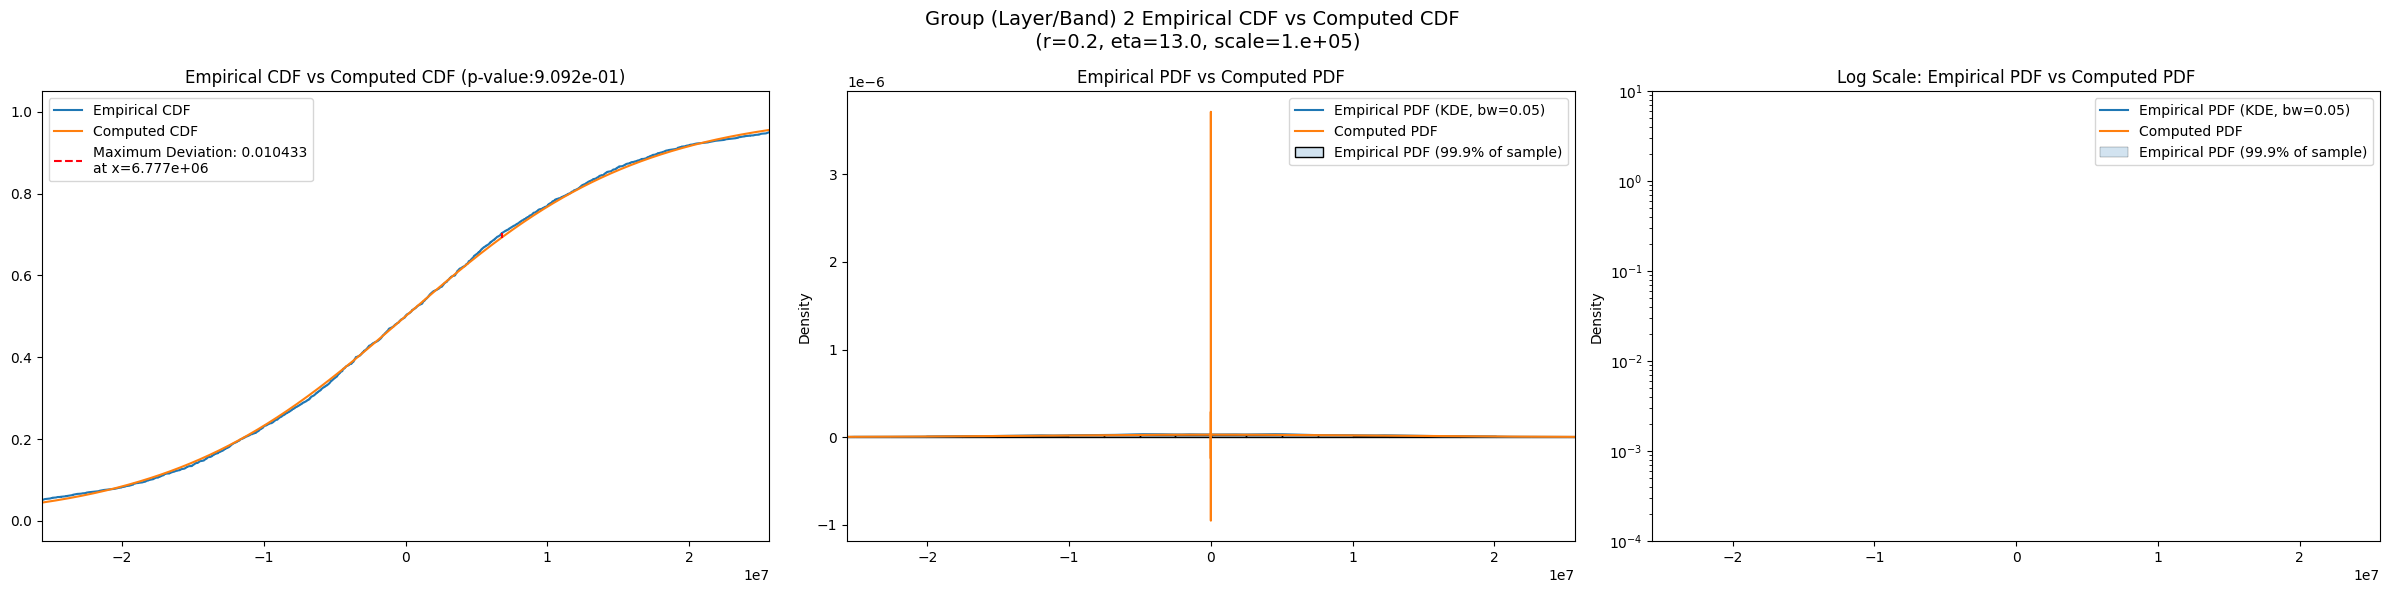

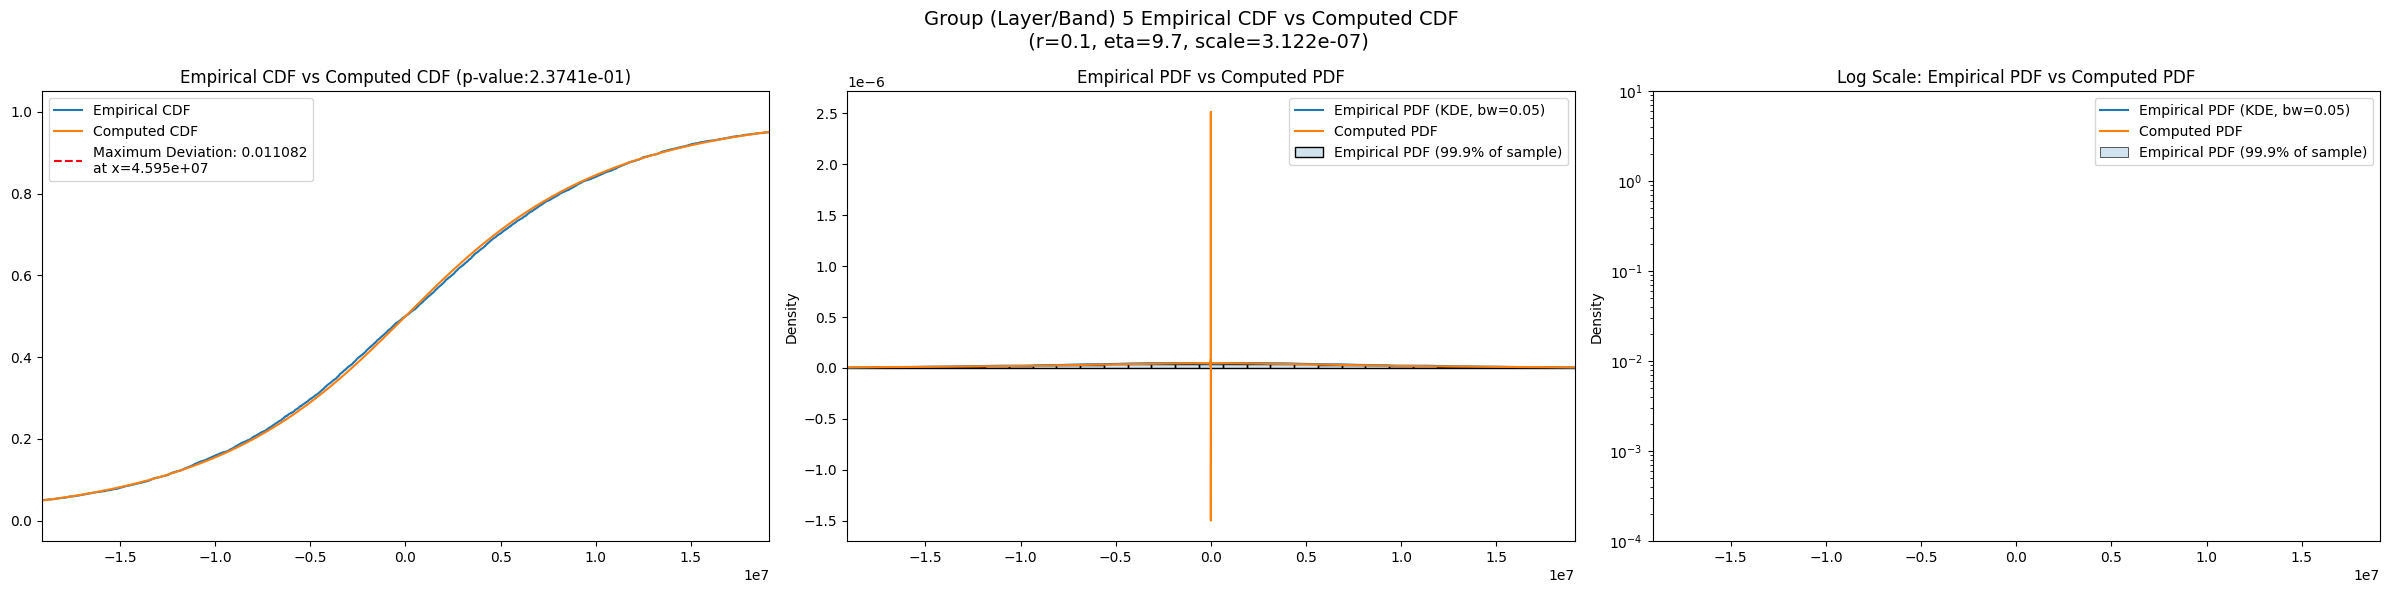

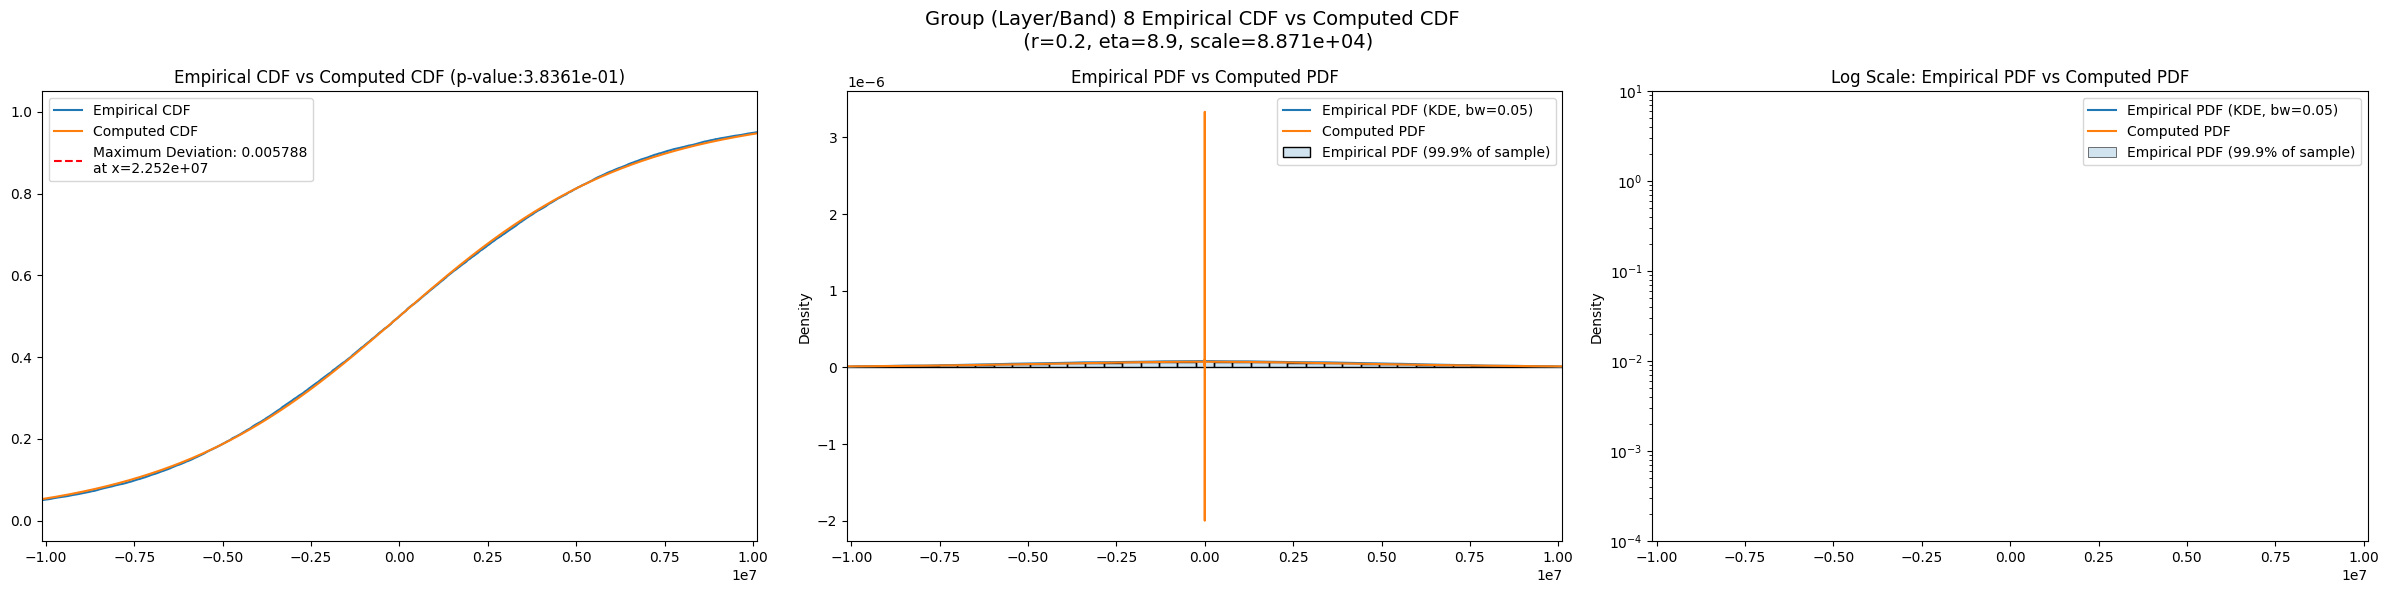

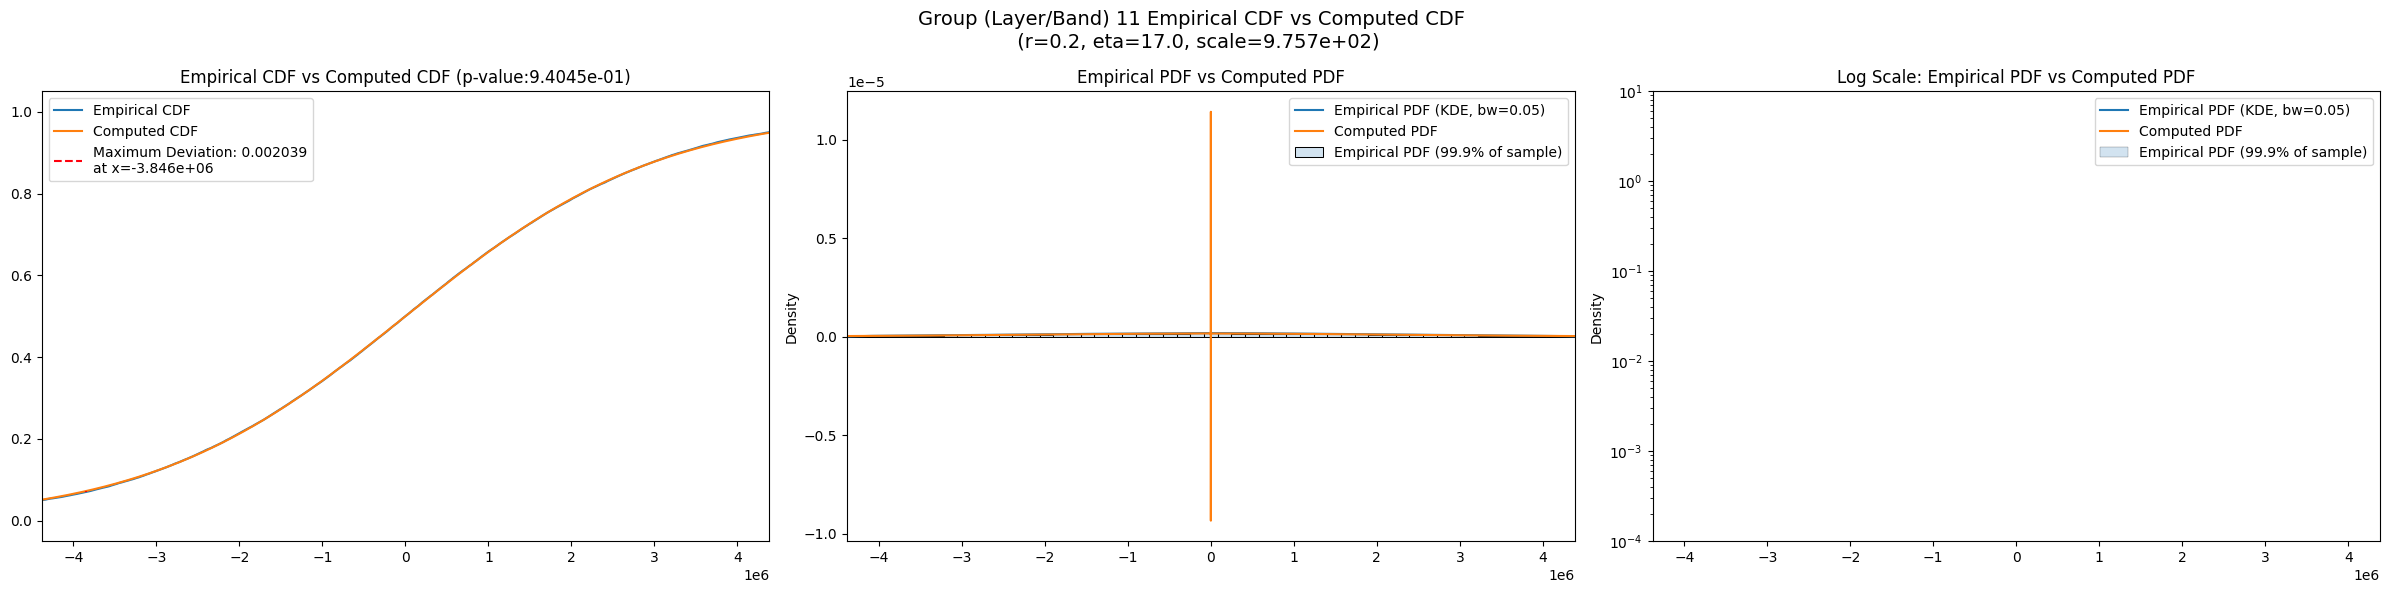

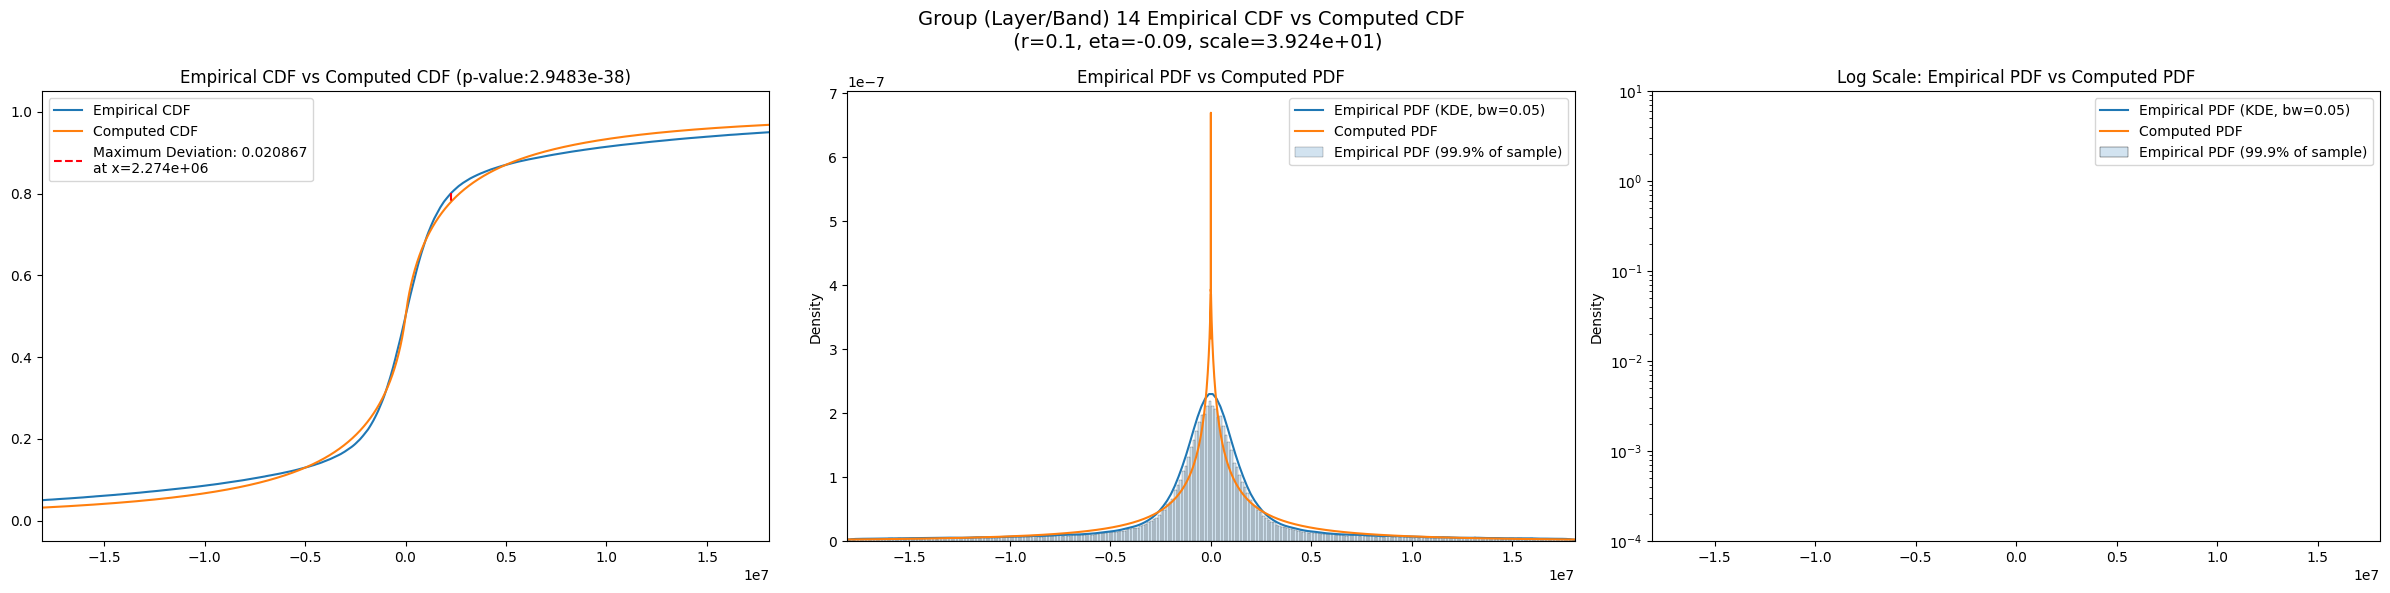

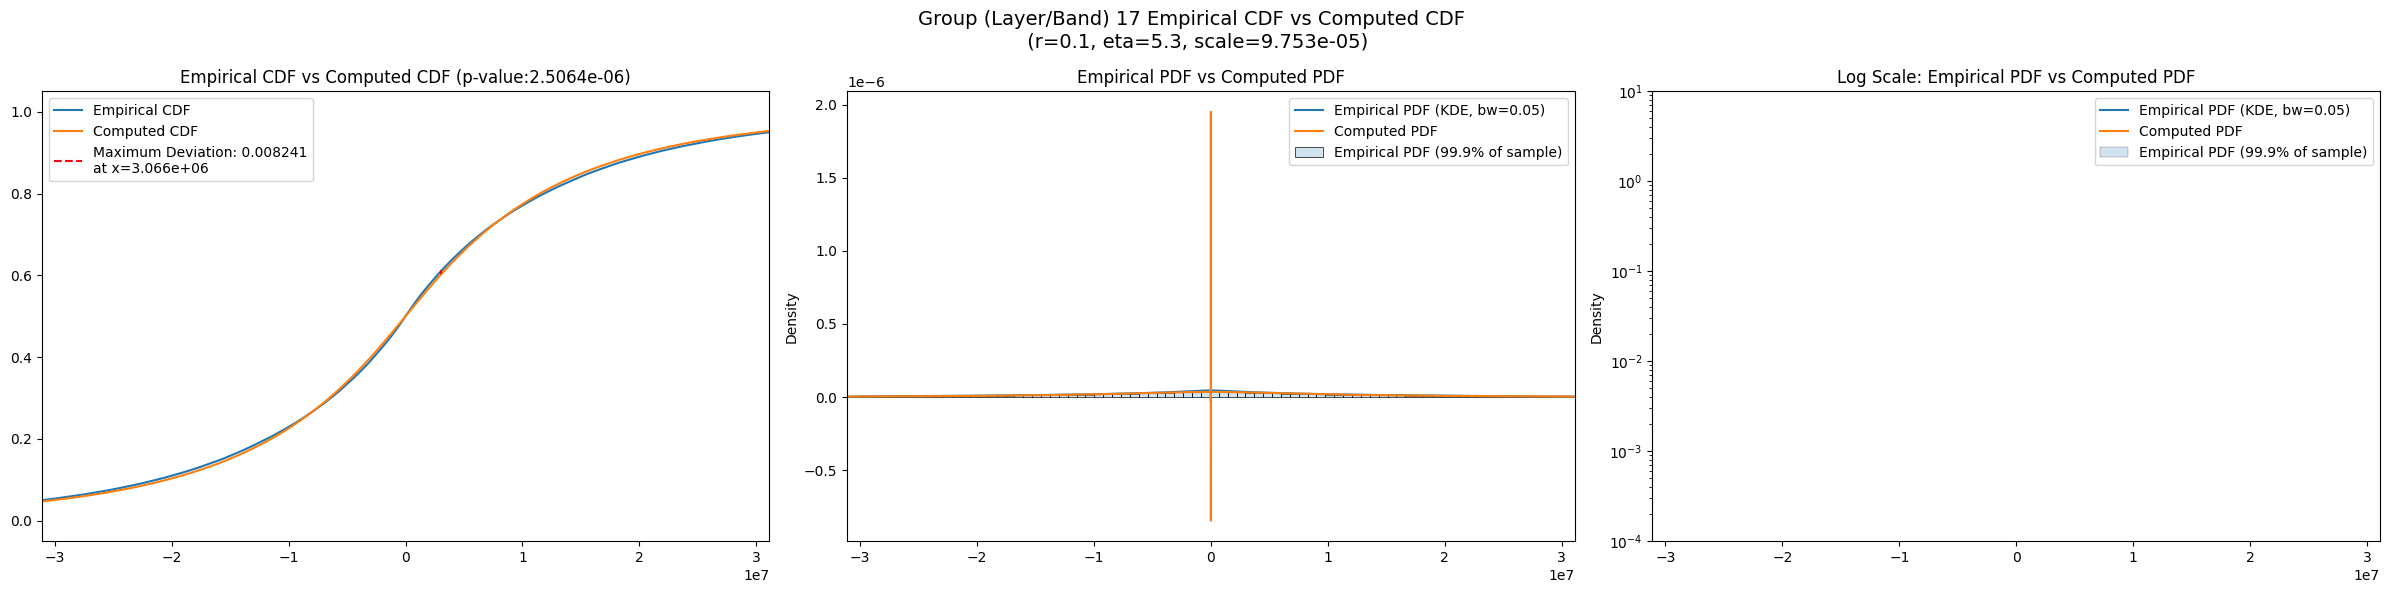

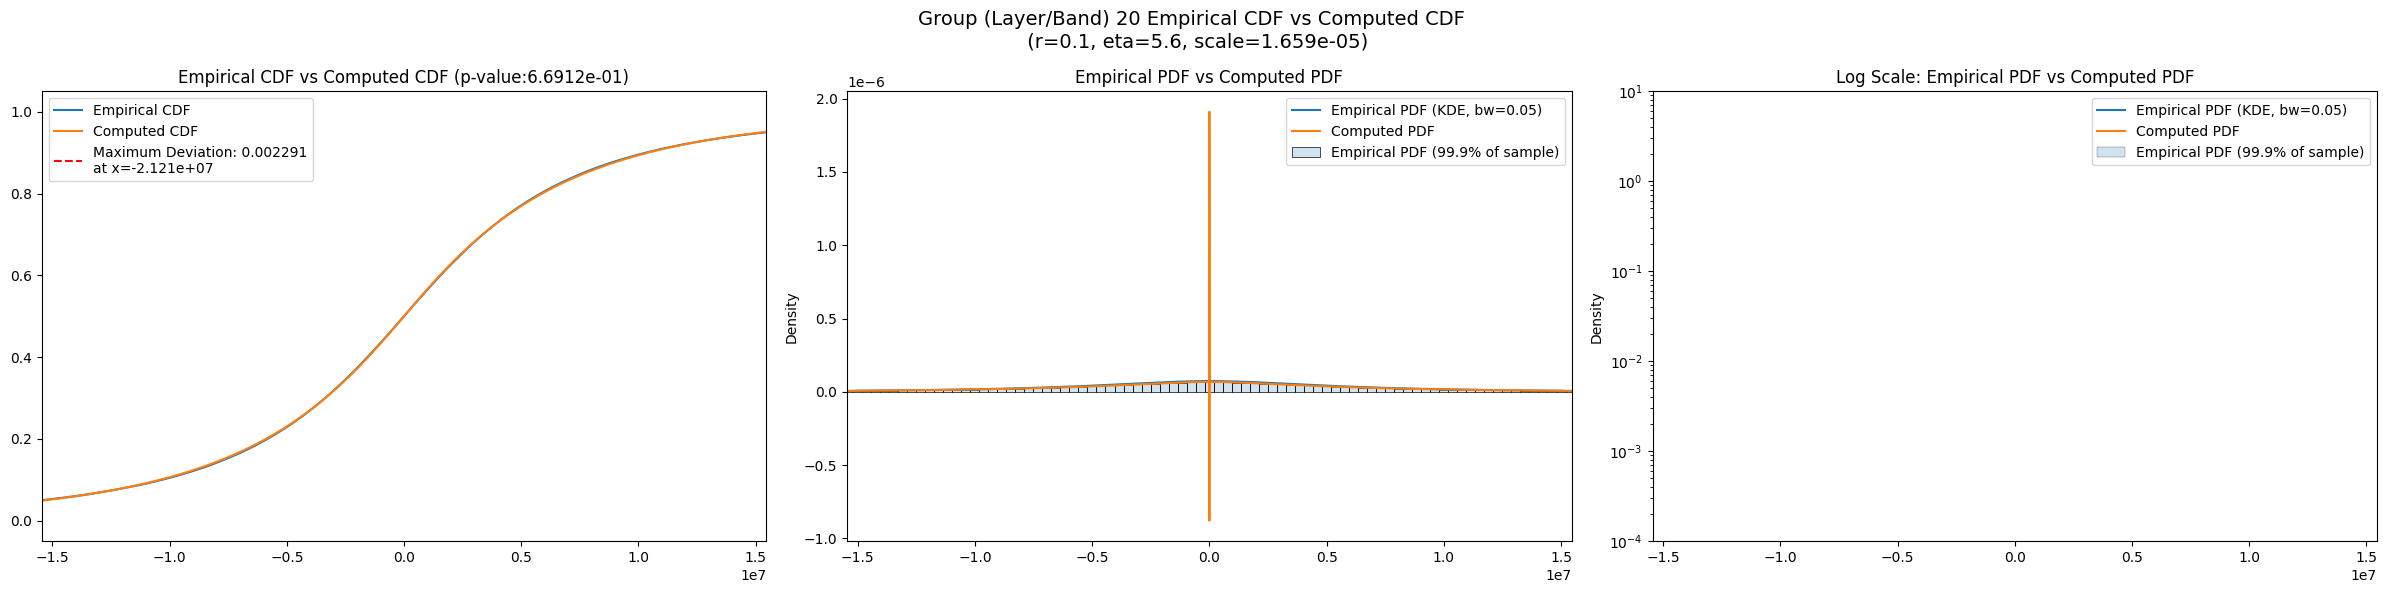

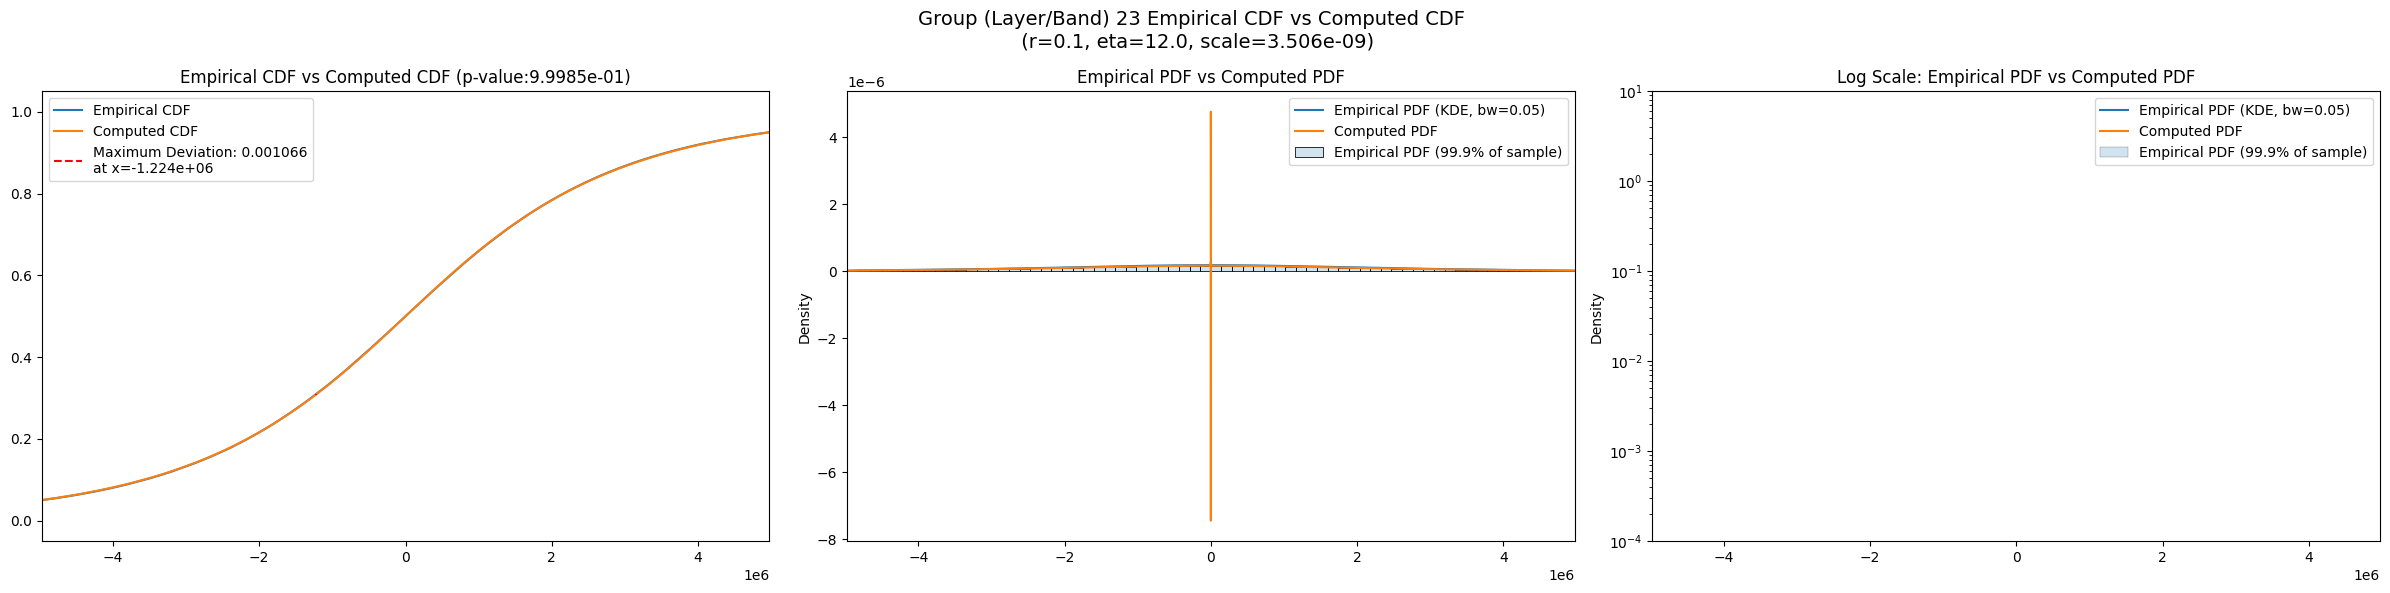

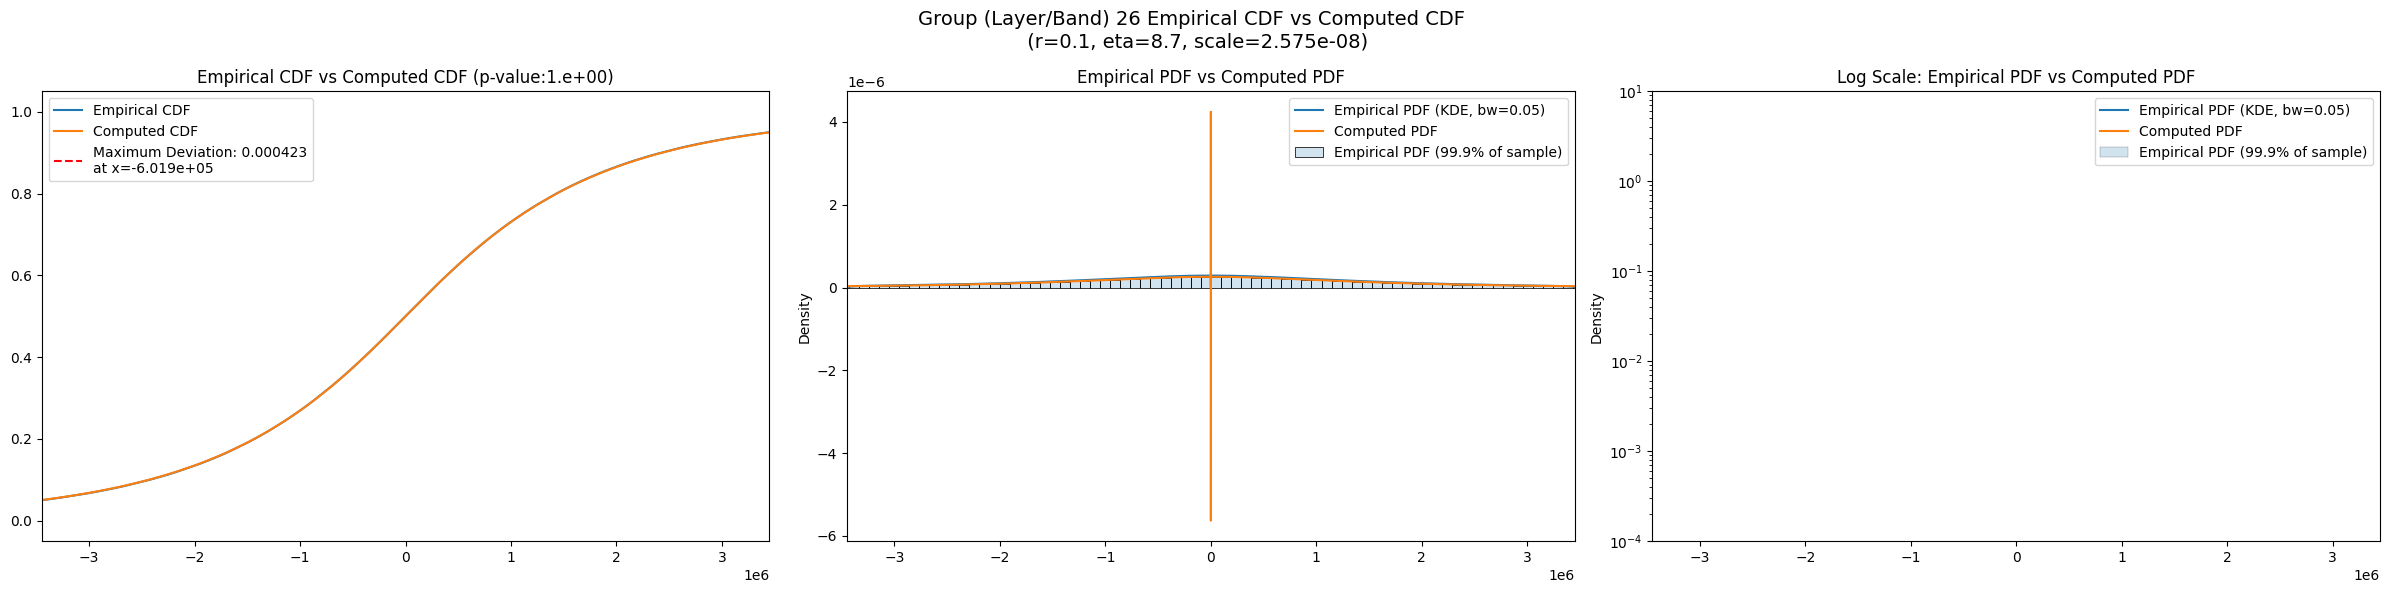

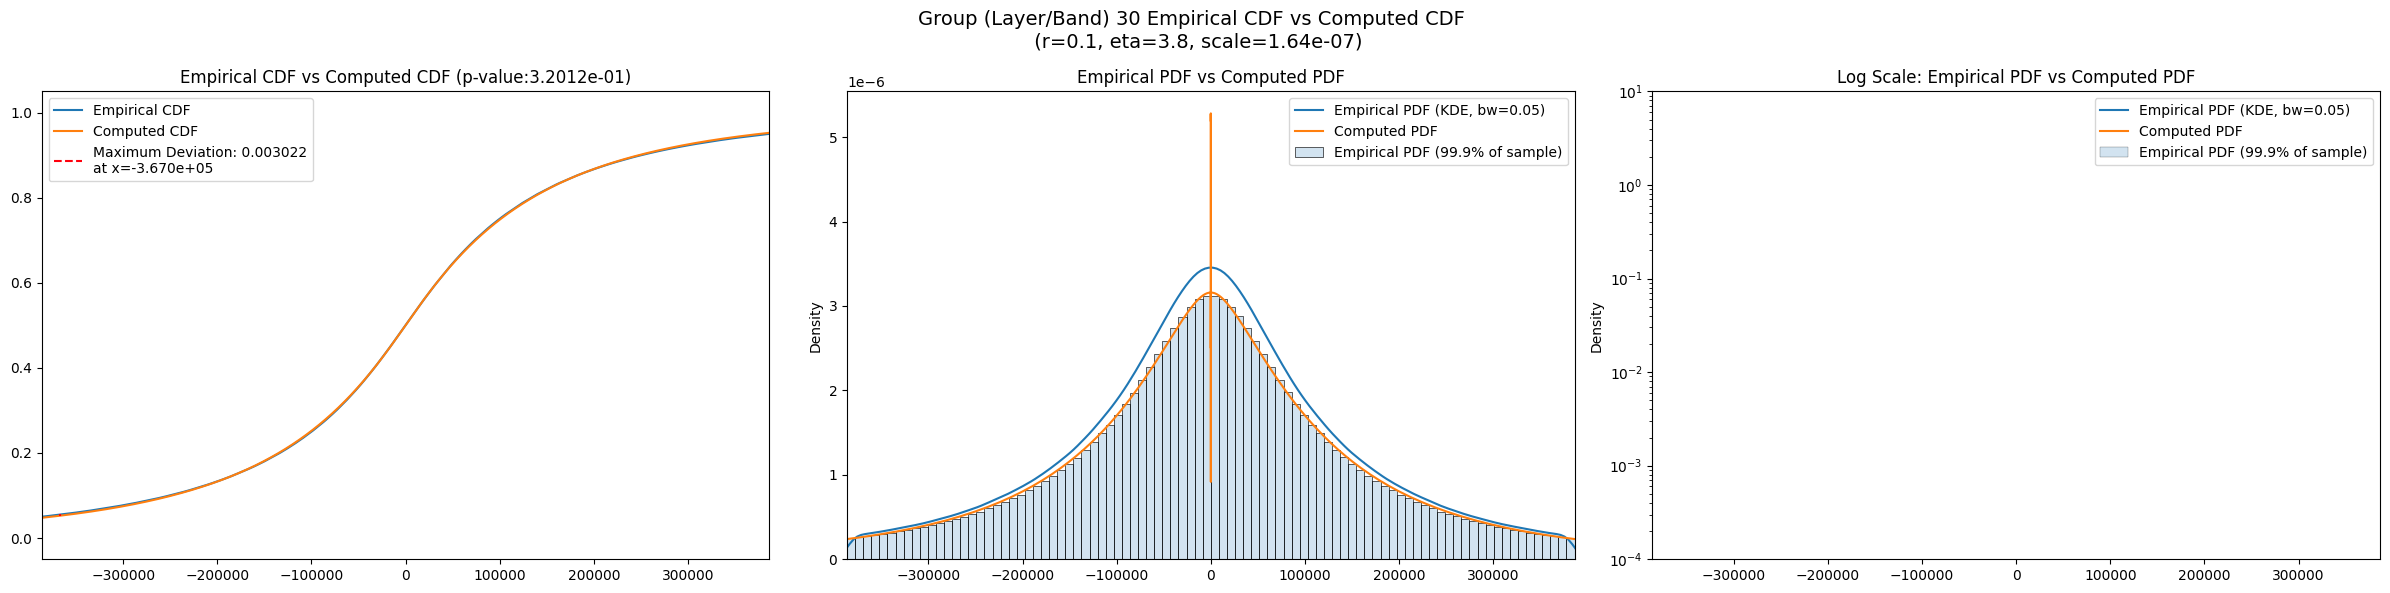

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,3.026685e+14,2.582338e+14,3.561559e+14,9.514625,3.957884,14.501236,1440.0,0.010433,0.2,13.0,...,1000000.0,0.423479,9.645180e-235,1000000.0,0.389789,1.511750e-197,1000000.0,0.366111,1.516390e-173,9.971729e-01
5,4.619870e+14,3.780415e+14,5.561503e+14,47.110716,38.247552,56.023000,4320.0,0.011082,0.1,9.7,...,1000000.0,0.396289,0.000000e+00,1000000.0,0.357046,0.000000e+00,1000000.0,0.333287,0.000000e+00,6.593557e-01
8,8.093079e+13,6.675209e+13,9.716262e+13,51.453747,35.541977,65.114411,12240.0,0.005788,0.2,8.9,...,1000000.0,0.337828,0.000000e+00,1000000.0,0.291746,0.000000e+00,1000000.0,0.267700,0.000000e+00,8.045110e-01
11,8.157558e+12,7.539994e+12,8.999805e+12,10.165148,2.219676,28.457157,33840.0,0.002039,0.2,17.0,...,1000000.0,0.207350,0.000000e+00,1000000.0,0.164506,0.000000e+00,1000000.0,0.139294,0.000000e+00,9.989162e-01
14,2.080089e+14,1.803587e+14,2.405816e+14,29.306278,17.520988,50.394668,93600.0,0.021139,0.1,-0.1,...,1000000.0,0.192583,0.000000e+00,1000000.0,0.147699,0.000000e+00,1000000.0,0.123771,0.000000e+00,7.796552e-36
17,3.882312e+14,3.622117e+14,4.166798e+14,5.403622,3.651718,8.761791,100000.0,0.008241,0.1,5.3,...,1000000.0,0.403133,0.000000e+00,1000000.0,0.366846,0.000000e+00,1000000.0,0.343487,0.000000e+00,2.506393e-06
20,1.055298e+14,9.708171e+13,1.151467e+14,8.822809,5.236424,19.120294,100000.0,0.002292,0.1,5.6,...,1000000.0,0.350965,0.000000e+00,1000000.0,0.306748,0.000000e+00,1000000.0,0.282735,0.000000e+00,6.688054e-01
23,1.033205e+13,9.617393e+12,1.125343e+13,7.130255,2.946967,23.835721,100000.0,0.001066,0.1,12.0,...,1000000.0,0.206653,0.000000e+00,1000000.0,0.162954,0.000000e+00,1000000.0,0.137820,0.000000e+00,9.998533e-01
26,4.816557e+12,4.516951e+12,5.143129e+12,4.306077,2.829495,8.496249,100000.0,0.000423,0.1,8.7,...,1000000.0,0.124194,0.000000e+00,1000000.0,0.085593,0.000000e+00,1000000.0,0.058802,5.254620e-301,1.000000e+00


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.010433,0.035671,0.010433,0.423479,0.389789,0.366111
5,0.011082,0.020624,0.011082,0.396289,0.357046,0.333287
8,0.005788,0.012262,0.005788,0.337828,0.291746,0.267700
11,0.002039,0.007378,0.002039,0.207350,0.164506,0.139294
14,0.021139,0.004437,0.020867,0.192583,0.147699,0.123771
17,0.008241,0.004293,0.008241,0.403133,0.366846,0.343487
20,0.002292,0.004293,0.002292,0.350965,0.306748,0.282735
23,0.001066,0.004293,0.001066,0.206653,0.162954,0.137820
26,0.000423,0.004293,0.000423,0.124194,0.085593,0.058802


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,3.026685e+14,0.010433,0.2,13.00,1.000000e+05,0.0
5,1.433303e+14,0.011082,0.1,9.70,3.121759e-07,75.0
8,4.066420e+13,0.005788,0.2,8.90,8.871326e+04,100.0
11,7.348870e+12,0.002039,0.2,17.00,9.756740e+02,75.0
14,1.721704e+14,0.020867,0.1,-0.09,3.924152e+01,100.0
17,3.882312e+14,0.008241,0.1,5.30,9.752666e-05,0.0
20,9.911460e+13,0.002292,0.1,5.60,1.658880e-05,50.0
23,9.762856e+12,0.001066,0.1,12.00,3.505546e-09,50.0
26,4.816557e+12,0.000423,0.1,8.70,2.575260e-08,0.0
